### Initiation

In [1]:
# To manipulate arrays
import numpy as np 
# To import images 

# To handle track DataFrames
import pandas as pd

# To import images
from skimage import io 
from skimage.io import imread

# For TrackPy
import trackpy as tp

# To make plots
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  

# To work inline; change to %matplotlib notebook for interactive plotting
%matplotlib inline 

# Napari 
%gui qt5 
from skimage import data
import napari

# To create interactive elements
import ipywidgets as widgets 
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout
from ipywidgets.embed import embed_minimal_html, dependency_state

# Image processing and filters
from skimage.filters import difference_of_gaussians

# Iteration tools such as groupby 
import itertools

# For directories 
import os

# For reloading a library when testing
import importlib

# For deleting/reloading modules in another file for code testing
import sys

# For statistics
from scipy import stats

# For curve fitting
from scipy.optimize import curve_fit

# Seaborn plotting
import seaborn as sns

# Import trackArrayTools
from trackArrayTools import *

#rSNAPsim_IP
cwd = os.getcwd()  # get current working director
os.chdir('../rSNAPsim_IP/rSNAPsim_IP/') # assume rSNAPsim_IP is  one directory up
import rSNAPsim_IP as rss_IP #importing rSNAPsim.
os.chdir(cwd) # change back to original current directory (the direc4tory this file is in)

from pathlib import Path, PureWindowsPath # for working with windows paths

from pytrackmate import trackmate_peak_import # for importing trackmate xml files

#del sys.modules['trackArrayTools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
#from trackArrayTools import *

         _____ _   _____    ____       _              ________ 
   _____/ ___// | / /   |  / __ \_____(_)___ ___     /  _/ __ \
  / ___/\__ \/  |/ / /| | / /_/ / ___/ / __ `__ \    / // /_/ /
 / /   ___/ / /|  / ___ |/ ____(__  ) / / / / / /  _/ // ____/ 
/_/   /____/_/ |_/_/  |_/_/   /____/_/_/ /_/ /_/  /___/_/      
                                                               



In [2]:
#os.chdir('C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Lab Management/Dry Lab/Python/Python Scripts/LabScripts')

### Set current working directory, track array filenames, and basic parameters

In [2]:
# Enter in the following:
crop_pad = 5    # specifies the size of crops in track arary. If 5, then crops are (2*5 + 1 = 11) x 11
xy_pixel_size = 130   # voxel  xy dimensions in crops
z_pixel_size = 500   # voxel z dimension

working_directory = r'E:\HarringtonineHandTracked\20210825\ago'  #r for string literal; can use windows path format
beads_path = r'E:\HarringtonineHandTracked\20210825\beads'

video_3D_directory = r'E:\HarringtonineHandTracked\20210825\ago'
video_3D_filename = r'TA19.tif'

[os.path.join(video_3D_directory,video_3D_filename)]

['E:\\HarringtonineHandTracked\\20210825\\ago\\TA19.tif']

In [3]:
# For display, so z and xy are shown properly when viewing track array
z_renorm = z_pixel_size/xy_pixel_size  

#  Track array filenames should be the following:
track_array_filename = 'Particles_' + video_3D_filename[:-4] + '_crop_pad_' + str(crop_pad) + '.tif' 
track_filename ='Particles_' + video_3D_filename[:-4] + '.csv'
[track_array_filename, track_filename]

['Particles_TA19_crop_pad_5.tif', 'Particles_TA19.csv']

### Creating Track Array (only done once using original 3D video and tracks)

In [173]:
# Loading the figure with beads so track array can be registered
# Dimension 1 is the number of channel. Red and Green. # Dimension 2 is the x axis. # Dimension 3 is the y axis.
figWithBeads = os.path.join(beads_path, 'BEADS01.tif')
im_beads = io.imread(figWithBeads) # reading the image

In [174]:
# Using rSNAPSim to get the homography matrix to align the green/blue channels with red
temp_obj_beads = rss_IP.BeadsAlignment(im_beads)
[my_homography,positions_green,positions_red] = temp_obj_beads.make_beads_alignment()  # !!! Adjusted Luis' code to spit this info out

The number of spots detected for the red channel are:
(6, 2)
The number of spots detected for the green channel are:
(6, 2)

The homography matrix is:


In [175]:
# Check that the homography matrix is working:
my_homography_inverse = np.linalg.inv(my_homography)  # This is the transformation we use to shift green to red
print('[original distance, corrected distance (shift red to green), corrected distance (shift green to red)]' )
for i in np.arange(len(positions_green)):
    g0=positions_green[i]
    g=np.dot(my_homography_inverse,[positions_green[i,0],positions_green[i,1],1])[0:2]  # Correct green/blue
    r0=positions_red[i]
    r=np.dot(my_homography,[positions_red[i,0],positions_red[i,1],1])[0:2]  # What you'll do: shift red to green
    print([np.linalg.norm(g0-r0),np.linalg.norm(g0-r),np.linalg.norm(g-r0)]) # Check corrections

[original distance, corrected distance (shift red to green), corrected distance (shift green to red)]
[2.7512064, 0.4288321986269202, 0.4258543397962668]
[2.406377, 0.2846638312261048, 0.2833750279705882]
[3.4732645, 0.09211826731961661, 0.09176984269815154]
[2.462465, 0.27550341494211344, 0.27523301710124953]
[3.5423856, 1.133038033518088, 1.1268785391008054]
[3.7841852, 0.5683107484258917, 0.5694387734850743]


In [176]:
# Read in the original 3D video 
video_3D = imread(os.path.join(video_3D_directory, video_3D_filename))

In [177]:
# Create track array tif video from the original 3D video
# This only needs to be done once. Thereafter, can skip and just work with track array itself
dims = list(video_3D.shape)
if len(dims) == 4:     # check if just a single channel video
    n_channels = 1
    n_frames, z_slices, height_y, width_x = dims
else:
    n_channels = min(dims)
    n_channels_index = dims.index(n_channels)   # find index of n_channels, which is assumed to be smallest dimension 
    dims.remove(n_channels)    
    video_3D = np.moveaxis(video_3D,n_channels_index,-1)  # move channels to last dimension of array (assumed by napari)
    n_frames, z_slices, height_y, width_x = dims

In [178]:
# Read in the tracking file from xml and convert to csv if needed 
xml_filename = video_3D_filename[:-4]+'.xml'
spots = trackmate_peak_import(os.path.join(video_3D_directory,xml_filename))
tracks=spots[['t','z','y','x']]
tracks.columns=['POSITION_T','POSITION_Z','POSITION_Y','POSITION_X']
tracks['TRACK_ID']=range(tracks.shape[0])
tracks.to_csv(os.path.join(video_3D_directory,'Particles_'+xml_filename[:-4]+'.csv'),index=False)

In [179]:
# Read in the tracking file that corresponds to the original 3D video
tracks = pd.read_csv(os.path.join(video_3D_directory, track_filename)) 
tracks

,POSITION_T,POSITION_Z,POSITION_Y,POSITION_X,TRACK_ID
0,0.0,0.0,254.952367,341.392880,0
1,0.0,0.0,261.615593,270.837120,1
2,0.0,0.0,263.697695,141.241579,2
3,0.0,0.0,264.367433,316.716223,3
4,0.0,0.0,272.676970,237.568684,4
...,...,...,...,...,...
2600,64.0,0.0,322.285912,150.850869,2600
2601,64.0,0.0,346.847422,139.062965,2601
2602,64.0,0.0,366.832008,184.129934,2602
2603,64.0,0.0,392.102130,239.686417,2603


In [18]:
viewer = napari.Viewer()
viewer.add_image(video_3D[:,:,:,:,0],name='red',blending="additive", scale=[z_renorm,1,1])
particles = tracks[['POSITION_T','POSITION_Z','POSITION_Y','POSITION_X']].values
viewer.add_points(particles, size=5, opacity = 0.3,
                edge_color = 'yellow',
                  face_color = 'yellow', symbol='ring')

In [181]:
create_particle_array_video(working_directory, track_array_filename, video_3D, 
                             tracks, crop_pad, xy_pixel_size, z_pixel_size, homography = my_homography)
# create_track_array_video(working_directory, track_array_filename, video_3D[0::10], tracks, crop_pad, xy_pixel_size, z_pixel_size)

### Track Array analysis one-by-one: best-z projection + 2D background subtract

In [214]:
# Just in case you want to update trackArrayTools without having to restart Kernel
#del sys.modules['trackArrayTools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
#from trackArrayTools import *

# Choose which track array you want to work with:
working_directory = r'C:\Users\tim_s\OneDrive - Colostate\Stasevich Lab\Our papers\Ago2Tethering\Revision\HarringtonineAnalysis'
track_array_filename = r'Particles_TA19_crop_pad_5.tif'

# The corresponding tracking file should be in the same directory and have the following filename: 
track_filename = track_array_filename[:-15] + '.csv'

# Read in the track array video 
track_array_vid = imread(os.path.join(working_directory , track_array_filename))  # Read in track array .tif file

# Read in tracks as a "dataframes (df)"
track_array_df = pd.read_csv(os.path.join(working_directory , track_filename))

# Make sure color channels are the last dimension of the track array
dims = list(track_array_vid.shape)
if len(dims) != 3:     # check if just a single channel video
    n_channels = min(dims)
    n_channels_index = dims.index(n_channels)
    track_array_vid = np.moveaxis(track_array_vid,n_channels_index,-1)

In [215]:
# Step 0: Create the track array object:
#del sys.modules['trackArrayTools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
#from trackArrayTools import *
ta = TrackArray(track_array_vid, track_array_df, crop_pad)

In [216]:
# Step 0.5: check if z's are offset in different channels
my_offset = [0,-1,-1]  ### For 3-color, could be [0,-1,-1]; BE CAREFUL, THIS WILL MAKE A MASK THAT IS SHIFTED IN Z FOR BLUE AND GREEN!!!
capsule_mask = ta.capsule_mask(crop_pad,crop_pad,2,1,0,z_offset=my_offset)
arr_bg = ta.local_background_subtract(ta.arr,capsule_mask)

# Check with napari
max = np.max(arr_bg,axis=(0,1,2)) # find max intensities for setting intensity range
my_range = [[0,max[ch]] for ch in np.arange(len(max))]
napari_viewer(arr_bg,[z_renorm,1,1],int_range=my_range,layer=[capsule_mask[:,:,:,0],capsule_mask[:,:,:,1]])

In [217]:
# Step 1: Best-z projection using offset from above
my_best_z_masks = ta.best_z_mask(1,0,z_offset = my_offset) # best-z mask w/ offset
best_z = ta.mask_projection(np.clip(ta.arr,0,1000000), my_best_z_masks) # best-z projection; clip to make sure data is +

# Check with napari
max = np.max(best_z,axis=(0,1)) # find max intensities for setting intensity range
my_range = [[0,max[ch]] for ch in np.arange(len(max))]
napari_viewer(best_z,[1,1],int_range=my_range)

In [218]:
# Step 2: Subtract background in donut rings from max projection  
best_z_bg = ta.local_background_subtract(best_z,ta.donut_mask_2D(5,1))

# Check with napari and show donut mask
max = np.max(best_z_bg,axis=(0,1)) # find max intensities for setting intensity range
my_range = [[0,max[ch]] for ch in np.arange(len(max))]
napari_viewer(best_z_bg,[1,1],int_range=my_range,layer=[ta.donut_mask_2D(5,1)])

In [219]:
# Output background-subtracted and max-z projected track array 
output_filename_path = os.path.join(working_directory , track_array_filename[0:-4] + '_bestz_bg-sub.tif')
io.imsave(output_filename_path,
        best_z_bg, 
        resolution=(1/xy_pixel_size,1/xy_pixel_size))
output_filename_path

'C:\\Users\\tim_s\\OneDrive - Colostate\\Stasevich Lab\\Our papers\\Ago2Tethering\\Revision\\HarringtonineAnalysis\\Particles_TA19_crop_pad_5_bestz_bg-sub.tif'

### Track Array analysis loop: best-z projection + 2D background subtract

In [328]:
# Loop everything above on a collection of images, if desired. 
working_directory = 'C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Our papers/Ago2Tethering/Revision/HarringtonineAnalysis/'
vids_TA =['TA05.tif','TA06.tif','TA02.tif', 'TA03.tif','TA07.tif','TA08.tif','TA10.tif','TA11.tif','TA12.tif'] 
vids_TL =['TL01.tif','TL02.tif','TL03.tif','TL06.tif','TL07.tif','TL08.tif','TL09.tif']  
vids_NT =['KDM01.tif','KDM02.tif','KDM03.tif','KDM04.tif']

# Choose a set of videos to loop through
vids = vids_TA
my_offset = [0,-1,-1]  ### BE CAREFUL, THIS WILL MAKE A MASK THAT IS SHIFTED IN Z FOR BLUE AND GREEN!!!
for vs in vids:
    # Get track array video and tracking files:
    track_array_filename = 'Particles_'+vs[0:-4]+'_crop_pad_5.tif'
    track_filename = track_array_filename[:-15] + '.csv'

    # Read in the track array video 
    track_array_vid = imread(working_directory + track_array_filename)  # Read in track array .tif file

    # Read in tracks as a "dataframes (df)"
    track_array_df = pd.read_csv(working_directory + track_filename)

    # Make sure color channels are the last dimension of the track array
    dims = list(track_array_vid.shape)
    if len(dims) != 3:     # check if just a single channel video
        n_channels = min(dims)
        n_channels_index = dims.index(n_channels)
        track_array_vid = np.moveaxis(track_array_vid,n_channels_index,-1)

    # Step 0: make the track array object
    ta = TrackArray(track_array_vid, track_array_df, crop_pad)
    
    # Step 1: Now do best-z projection with offset
    my_best_z_masks = ta.best_z_mask(1,0,z_offset = my_offset) # this part is same as above
    best_z = ta.mask_projection(np.clip(ta.arr,0,1000000), my_best_z_masks) # best-z projection; clip to make sure data is +
    
    # Step 2: Subtract background in donut rings from max projection  
    best_z_bg = ta.local_background_subtract(best_z,ta.donut_mask_2D(5,1))

    # Output background-subtracted and max-z projected track array 
    output_filename_path = os.path.join(working_directory , track_array_filename[0:-4] + '_bestz_bg-sub.tif')
    io.imsave(output_filename_path,
            best_z_bg, 
            resolution=(1/xy_pixel_size,1/xy_pixel_size))
    
output_filename_path


'C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Our papers/Ago2Tethering/Revision/HarringtonineAnalysis/Particles_TA08_crop_pad_5_bestz_bg-sub.tif'

### Combining track arrays together for global analysis

In [5]:
# del sys.modules['trackArrayTools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
# from trackArrayTools import *

In [2]:
# Specify basic track array parameters (in case not done above)
crop_pad = 5    # specifies the size of crops in track arary. If 5, then crops are (2*5 + 1 = 11) x 11
xy_pixel_size = 130   # voxel  xy dimensions in crops
z_pixel_size = 500   # voxel z dimension

# Specify working directory and files you want to read in:
working_directory = 'C:/Users/StasLab/OneDrive - Colostate/Stasevich Lab/Our papers/Ago2Tethering/Revision/HarringtonineAnalysis/'
# full file listing
vids_TA =['TA05.tif','TA06.tif','TA02.tif','TA03.tif','TA04.tif','TA07.tif','TA08.tif','TA10.tif','TA11.tif','TA12.tif'] 
vids_TL =['TL01.tif','TL02.tif','TL03.tif','TL06.tif','TL07.tif','TL08.tif','TL09.tif','TL10.tif','TL11.tif','TL12.tif','TL13.tif','TL14.tif']  
vids_NT=['KDM01.tif','KDM02.tif','KDM03.tif','KDM04.tif', 'KDM06.tif']

# A list of which replicate each vid above corresponds to :
replicates_TA = [1,1,1,2,2,2,2,3,3,3]
replicates_TL = [2,3,3,4,4,4,4,5,5]  #Rep 3 may be bad as HT was left on counter during TA expts and resused for TL
replicates_NT = [1,1,1,1,2]

#Removing Rep 3:
vids_TA =['TA05.tif','TA06.tif','TA02.tif','TA03.tif','TA04.tif','TA07.tif','TA08.tif','TA17.tif','TA18.tif','TA19.tif'] 
vids_TL =['TL01.tif','TL06.tif','TL07.tif','TL08.tif','TL09.tif','TL10.tif','TL11.tif','TL12.tif','TL13.tif','TL14.tif']  
vids_NT=['KDM01.tif','KDM02.tif','KDM03.tif','KDM04.tif', 'KDM06.tif']

# All one rep:
replicates_TA = [1,1,1,1,1,1,1,1,1,1]
replicates_TL = [1,1,1,1,1,1,1,1,1,1]  #Rep 3 may be bad as HT was left on counter during TA expts and resused for TL
replicates_NT = [1,1,1,1,1]

#Removing Anamolous cells:
vids_TA =['TA05.tif','TA06.tif','TA02.tif','TA03.tif','TA04.tif','TA07.tif','TA08.tif','TA17.tif','TA18.tif'] 
vids_TL =['TL01.tif','TL07.tif','TL08.tif','TL09.tif','TL10.tif','TL11.tif','TL12.tif','TL13.tif','TL14.tif']  
vids_NT=['KDM01.tif','KDM02.tif','KDM03.tif','KDM04.tif', 'KDM06.tif']

# All one rep:
replicates_TA = [1,1,1,1,1,1,1,1,1]
replicates_TL = [1,1,1,1,1,1,1,1,1]  #Rep 3 may be bad as HT was left on counter during TA expts and resused for TL
replicates_NT = [1,1,1,1,1]


# A list of expt. names:
my_expts = ('Ago2', '\u03B2-gal','NT')

# The name of the 2D bg-subtracted crop array vids
track_array_filenames_TA = ['Particles_' + videos[:-4] + '_crop_pad_' + 
                          str(crop_pad) + '_bestz_bg-sub.tif' for videos in vids_TA]
track_array_filenames_TL = ['Particles_' + videos[:-4] + '_crop_pad_' + 
                           str(crop_pad) + '_bestz_bg-sub.tif' for videos in vids_TL]
track_array_filenames_NT = ['Particles_' + videos[:-4] + '_crop_pad_' + 
                           str(crop_pad) + '_bestz_bg-sub.tif' for videos in vids_NT]

In [3]:
# Read in all track array videos and corresponding tracking files:
track_array_vids_TA = [imread(working_directory + i) for i in track_array_filenames_TA]  # Read in track array .tif file
track_files_TA = [pd.read_csv(working_directory + 'Particles_' + videos[:-4]+'.csv') 
                  for videos in vids_TA] 

# add 'File' column to dataframes to keep track of which row in the track array comes from which file
for i in np.arange(len(track_files_TA)):
    track_files_TA[i]['File'] =  ('Particles_' + vids_TA[i][:-4]+'.csv')

# repeat for other experiments (TL and NT):
track_array_vids_TL = [imread(working_directory + i) for i in track_array_filenames_TL]  # Read in track array .tif file
track_files_TL = [pd.read_csv(working_directory + 'Particles_' + videos[:-4]+'.csv') 
                  for videos in vids_TL] 

for i in np.arange(len(track_files_TL)):
    track_files_TL[i]['File'] =  ('Particles_' + vids_TL[i][:-4]+'.csv')
    
track_array_vids_NT = [imread(working_directory + i) for i in track_array_filenames_NT]  # Read in track array .tif file
track_files_NT = [pd.read_csv(working_directory + 'Particles_' + videos[:-4]+'.csv') 
                  for videos in vids_NT] 

for i in np.arange(len(track_files_NT)):
    track_files_NT[i]['File'] =  ('Particles_' + vids_NT[i][:-4]+'.csv')

# Make individual track arrays, so can check one-by-one:
tas = [TrackArray(np.array([track_array_vids_TA[i]]), track_files_TA[i], crop_pad) 
       for i in np.arange(len(track_array_vids_TA))]
tls = [TrackArray(np.array([track_array_vids_TL[i]]), track_files_TL[i], crop_pad) 
       for i in np.arange(len(track_array_vids_TL))]
nts = [TrackArray(np.array([track_array_vids_NT[i]]), track_files_NT[i], crop_pad) 
       for i in np.arange(len(track_array_vids_NT))]

In [8]:
#View the background-subtracted track array and disk mask to measure intensities in:
myn=1
print(vids_TL[myn])
arrs = tls
napari_viewer(arrs[myn].arr,[1,1],int_range=[[0,10000] for i in np.arange(arrs[myn].n_channels())],
             layer=[arrs[myn].donut_mask_2D(5,1),arrs[myn].disk_mask_2D(3)])

TL07.tif


### Global Analysis

In [4]:
# Choose working directory where you want to save figures and data:
os.chdir('C:/Users/StasLab/OneDrive - Colostate/Stasevich Lab/Our papers/Ago2Tethering/Revision/HarringtonineAnalysis/Plots/')

In [5]:
# Make dataframes from the measurements of intensities in 2D disk masks:
chs = ['mRCK Int. (a.u.)', 'Trnl. Int. (a.u.)', 'Tether Int. (a.u.)']
rchs = ['Renorm. '+ c for c in chs]

#The photobleach corrections for each replicate.Found by quantifying total fluroescence decay vs. time.
k_pb = [[0.0006,0.0006,0.0006]]

k_pbs = [[0.0011,0.00079,0.00078], # rep 1
         [0.00074,0.00090,0.00047], # rep 2
         [0.00090,0.0013,0.0018],
           [0.00090,0.0013,0.0018]] # rep 3/4
        

df_tas = [tas[i].measure_intensity_in_mask_df(tas[i].arr, np.array([tas[i].disk_mask_2D(3)]), dt=1, 
            start_frame=5, renorm_frames=[5,7], bg_frames=[50,64], file=vids_TA[i], ch_names = chs, replicate=replicates_TA[i], 
            exp=my_expts[0], k_pb=k_pb, ignore_val = -1) for i in np.arange(len(tas))]
df_tls = [tls[i].measure_intensity_in_mask_df(tls[i].arr, np.array([tls[i].disk_mask_2D(3)]), dt=1, 
            start_frame=5, renorm_frames=[5,7], bg_frames=[50,64], file=vids_TL[i], ch_names = chs, replicate=replicates_TL[i], 
            exp=my_expts[1], k_pb=k_pb, ignore_val = -1) for i in np.arange(len(tls))]
df_nts = [nts[i].measure_intensity_in_mask_df(nts[i].arr, np.array([nts[i].disk_mask_2D(3)]), dt=1, 
            start_frame=5, renorm_frames=[5,7], bg_frames=[50,64], file=vids_NT[i], ch_names = chs, replicate=replicates_NT[i], 
            exp=my_expts[2], k_pb=k_pb, ignore_val = -1) for i in np.arange(len(nts))]

In [6]:
# Concatenate everything together:
df_ta = pd.concat(df_tas, axis=0, sort=False) 
df_tl = pd.concat(df_tls, axis=0, sort=False) 
df_nt = pd.concat(df_nts, axis=0, sort=False)
df_all = pd.concat([df_ta,df_tl], axis = 0, sort=False)
df_all.to_csv('Harringtonine-data.csv')
df_all[df_all['File']=='TA05.tif'].head()

,Crop Row,Frame,Original Time (min),Time (min),mRCK Int. (a.u.),Trnl. Int. (a.u.),Tether Int. (a.u.),Renorm. mRCK Int. (a.u.),Renorm. Trnl. Int. (a.u.),Renorm. Tether Int. (a.u.),Renorm by Row mRCK Int. (a.u.),Renorm by Row Trnl. Int. (a.u.),Renorm by Row Tether Int. (a.u.),BG mRCK Int. (a.u.),BG Trnl. Int. (a.u.),BG Tether Int. (a.u.),Expt.,Rep.,File
0,0.0,0.0,0.0,-5.0,24.354719,37.583156,0.280974,0.676893,1.469242,4.086238,0.954430,1.551235,0.023683,6.703193,0.236675,-4.217958,Ago2,1,TA05.tif
1,0.0,1.0,1.0,-4.0,25.818540,44.155264,5.081179,1.115249,1.767288,2.054307,1.011795,1.822497,0.428284,6.703193,0.236675,-4.217958,Ago2,1,TA05.tif
2,0.0,2.0,2.0,-3.0,20.958109,13.746103,40.174522,-0.357588,0.387434,-12.816668,0.821321,0.567367,3.386240,6.703193,0.236675,-4.217958,Ago2,1,TA05.tif
3,0.0,3.0,3.0,-2.0,23.021325,58.503101,13.050033,0.261901,2.417989,-1.318055,0.902176,2.414700,1.099964,6.703193,0.236675,-4.217958,Ago2,1,TA05.tif
4,0.0,4.0,4.0,-1.0,13.704791,8.771801,37.291874,-2.557579,0.161458,-11.589869,0.537073,0.362054,3.143267,6.703193,0.236675,-4.217958,Ago2,1,TA05.tif


In [7]:
vids_NT

['KDM01.tif', 'KDM02.tif', 'KDM03.tif', 'KDM04.tif', 'KDM06.tif']

[(0.0, 1.0)]

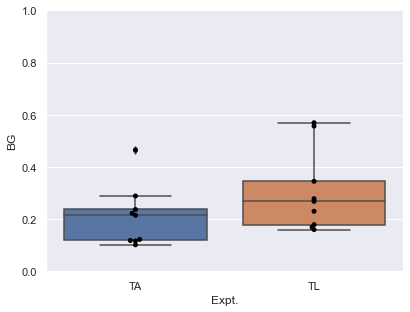

In [8]:
plt.rcParams["figure.figsize"] = (6.4,4.8)
my_files = vids_TA+vids_TL#+vids_NT
bg_df = pd.DataFrame(list(dict.fromkeys(df_all['BG '+chs[1]])),columns=['BG'])
bg_df['File']=list(dict.fromkeys(df_all['File']));
bg_df['Expt.']=[my_files[i][0:2] for i in np.arange(len(my_files))]
g1=sns.boxplot(y='BG', x = 'Expt.', data=bg_df)
g1=sns.swarmplot(y='BG', x = 'Expt.', data=bg_df, 
                 palette=['black','black','black']) 
g1.set(ylim=(-0, 1))

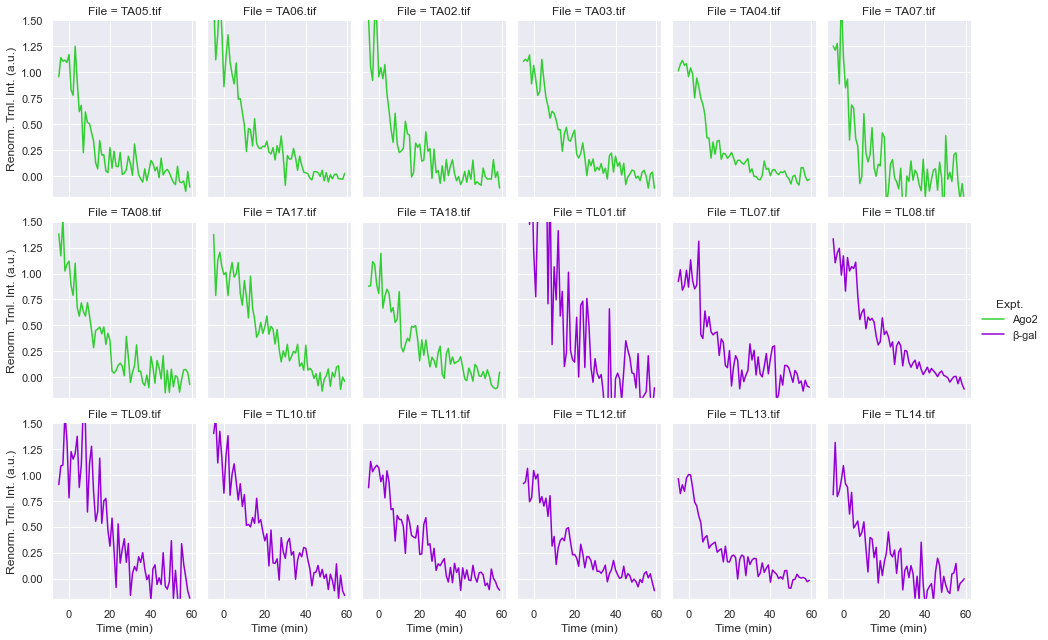

In [9]:
# Display all cells one-by-one. 1-19 Ago2; 100-1700 LacZ
my_palette =['limegreen','darkviolet']
g=sns.relplot(x="Time (min)", y=rchs[1],hue="Expt.",col="File", kind='line', 
            data=df_all, palette=my_palette,legend=True,col_wrap=6,
              height=3, aspect=.75,ci=None)
g.set(ylim=(-0.2, 1.5))

In [10]:
df_all[ (df_all['File']=='TA05.tif') & (df_all['Frame']==0)  ].head()

,Crop Row,Frame,Original Time (min),Time (min),mRCK Int. (a.u.),Trnl. Int. (a.u.),Tether Int. (a.u.),Renorm. mRCK Int. (a.u.),Renorm. Trnl. Int. (a.u.),Renorm. Tether Int. (a.u.),Renorm by Row mRCK Int. (a.u.),Renorm by Row Trnl. Int. (a.u.),Renorm by Row Tether Int. (a.u.),BG mRCK Int. (a.u.),BG Trnl. Int. (a.u.),BG Tether Int. (a.u.),Expt.,Rep.,File
0,0.0,0.0,0.0,-5.0,24.354719,37.583156,0.280974,0.676893,1.469242,4.086238,0.954430,1.551235,0.023683,6.703193,0.236675,-4.217958,Ago2,1,TA05.tif
65,1.0,0.0,0.0,-5.0,16.964320,36.494484,-9.456917,-1.556489,1.419848,8.213418,0.891826,1.389216,-1.399033,6.703193,0.236675,-4.217958,Ago2,1,TA05.tif
130,2.0,0.0,0.0,-5.0,23.966835,31.445192,9.463509,0.559674,1.190753,0.194434,0.873727,1.944434,0.485764,6.703193,0.236675,-4.217958,Ago2,1,TA05.tif
195,3.0,0.0,0.0,-5.0,31.407908,42.663553,25.050150,2.808370,1.699748,-6.411603,1.449356,2.071742,95.995824,6.703193,0.236675,-4.217958,Ago2,1,TA05.tif
260,4.0,0.0,0.0,-5.0,16.827335,1.547211,37.237500,-1.597886,-0.165766,-11.576929,0.649976,0.227926,1.574545,6.703193,0.236675,-4.217958,Ago2,1,TA05.tif


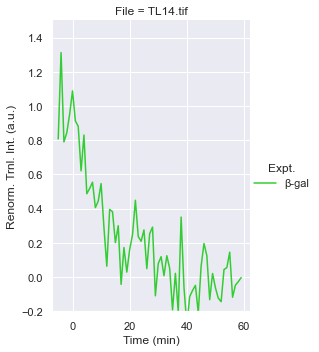

In [11]:
# Display all cells one-by-one. 1-19 Ago2; 100-1700 LacZ
my_palette =['limegreen']
g=sns.relplot(x="Time (min)", y=rchs[1],hue="Expt.",kind='line',col='File',
            data=df_all[(df_all['File']=='TL14.tif')], palette=my_palette,legend=True,
              height=5, aspect=.75,ci=None)
g.set(ylim=(-0.2, 1.5))
g.set(xlim=(-7,62))

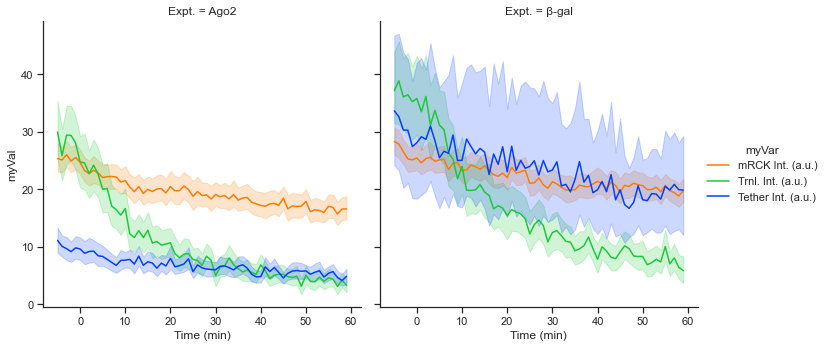

In [12]:
# Basic settings for all subsequent plots:
sns.set(font="Arial")
sns.set_style("white")
sns.set_style('ticks')
# melt dataframe to plot multiple columns (y-vals) vs a single column (x-vals):
df_temp=pd.melt(df_all, id_vars=['Time (min)','Expt.','Rep.'],var_name='myVar', value_name='myVal',
    value_vars=chs)

# Choose palette, plot, and save:
my_palette = [sns.color_palette("bright")[1],sns.color_palette("bright")[2],
              sns.color_palette("bright")[0]]
g=sns.relplot(x='Time (min)', y='myVal', hue='myVar', col='Expt.',data = df_temp, kind='line',
            palette=my_palette,legend=True,aspect=1)
plt.savefig('Harringtonine-AvgAll-3-color.svg', format = 'svg', dpi=300)

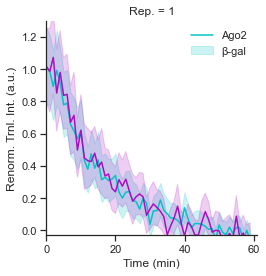

In [13]:
#df_all.reset_index(level=0, inplace=True)
sns.set_style('ticks')
#sns.set_style("whitegrid")
# Compare Ago2 tethering (blue) to lacZ tethering (orange) in replicates
my_palette=[(0,0.77,0.78),(.67,.05,.76)]
g=sns.relplot(x="Time (min)", y=rchs[1],col="Rep.",hue="Expt.", kind='line', 
            data=df_all[(df_all['Expt.']!='NT')], palette=my_palette,legend=False,height=4, aspect=1)
g.set(ylim=(-0.03, 1.3))
g.set(xlim=(-0.03, 61))
plt.legend(('Ago2', '\u03B2-gal'),loc='upper right',ncol=1, frameon=False)
plt.savefig('Harringtonine-ReplicatesVRevision.svg', format = 'svg', dpi=300)

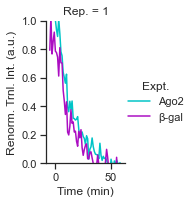

In [14]:
# Compare Ago2 tethering (blue) to lacZ tethering (orange) in replicates
my_palette=[(0,0.77,0.78),(.67,.05,.76)]
g=sns.relplot(x="Time (min)", y=rchs[1],col="Rep.",hue="Expt.", kind='line', 
            data=df_all[(df_all[chs[2]]<50)&(df_all['Expt.']!='NT')], palette=my_palette,legend=True,height=3, aspect=.75,ci=None)
g.set(ylim=(0, 1))

### Fitting HT data w/ tanh function

In [15]:
# Phenomenonlogical function to fit elongation rate v (in aa/sec) given t_half (in min)
# and length of trancript L (in aa)
def my_tanh(t,t_half,v,L):
    return (1-np.tanh(  (t-t_half)/(L/(2*v*60))  ))/2
# tt = np.linspace(0, 60, 200)
# plt.plot(tt, my_tanh(tt,10,5,1900))
# plt.ylim(0,1)
# plt.show() # or plt.savefig('foo.eps')

In [16]:
# Fit all the data to the two-state Harringtonine run-off model:
sns.set_style('ticks')

# Function to fit, plugging in values for tag lengths
def myf(t,t_half,v):
    return my_tanh(t,t_half,v,1885)  # Spaghetti monster tag = 336 aa; KDM5B = 1549 aa 

# Define some columns for the data frame to keep track of expt., rep, and file:
my_files = vids_TA+vids_TL#+vids_NT
expt_list = [my_expts[0]]*len(df_ta['File'].unique()) + [my_expts[1]]*len(df_tl['File'].unique())# + [my_expts[2]]*len(df_nt['File'].unique())# Expt. list]
rep_list = replicates_TA+replicates_TL#+replicates_NT  # Join replicate lists

# Make an empty numpy array to hold all the fits:
fit_data = np.zeros([len(my_files),2])

# Loop through the data
for i in np.arange(len(my_files)):


    # Choose the appropriate data for each file
    temp_data =df_all[(df_all['File']==my_files[i]) &
          (df_all['Time (min)']>=0)].groupby('Time (min)').agg('mean')[rchs[1]]
    x_vals = temp_data.index[0:25]                      
    y_vals = temp_data.values[0:25]

    # Fit the datam to the function
    pars, cov = curve_fit(f=myf, xdata=x_vals, ydata=y_vals, p0=[10,13], bounds=(0, np.inf), maxfev=2000)

    # Fill the array with info to keep track of expt., rep, and file: 
    fit_data[i]= pars  # convert elongation rates from aa/min to aa/sec   
    df_fit = pd.DataFrame(fit_data, columns=['t_half (min)', 'runoff rate (aa/sec)'])

# Make the dataframe    
df_fits = pd.DataFrame(fit_data, columns=['t_half (min)', 'runoff rate (aa/sec)'])
df_fits['Expt.'] = expt_list
df_fits['Rep.'] = rep_list
df_fits['File'] = my_files     

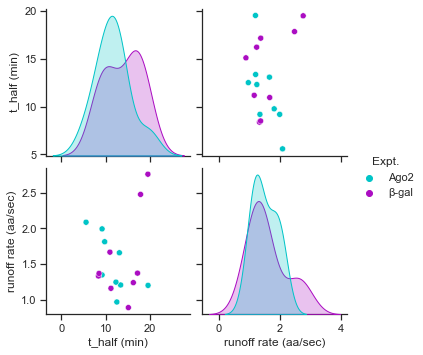

In [17]:
# Plot it all
g = sns.pairplot(df_fits,vars=['t_half (min)','runoff rate (aa/sec)'], hue="Expt.", palette=[(0,0.77,0.78),(.67,.05,.76)], 
                 diag_kind="kde", height=2.5)

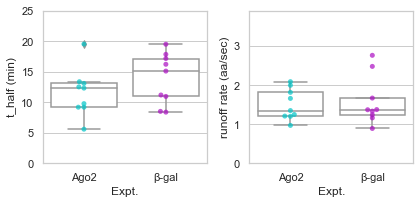

In [18]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(6, 3))
gs = fig.add_gridspec(1, 2)
ax = fig.add_subplot(gs[0, 0])
g1 = sns.boxplot(x='Expt.',y='t_half (min)', data=df_fits[df_fits['Expt.']!='NT'],
                    palette=['white','white'])
sns.swarmplot(x='Expt.', y='t_half (min)', data=df_fits[df_fits['Expt.']!='NT'],
             palette=[(0,0.77,0.78),(.67,.05,.76)], alpha=0.7) 
g1.set(ylim=(0, 25))
ax = fig.add_subplot(gs[0, 1])
g1=sns.boxplot(x='Expt.',y='runoff rate (aa/sec)', data=df_fits[df_fits['Expt.']!='NT'],
                  palette=['white','white'], showfliers=False)
sns.swarmplot(x='Expt.', y='runoff rate (aa/sec)', data=df_fits[df_fits['Expt.']!='NT'], 
              palette=[(0,0.77,0.78),(.67,.05,.76)], alpha=0.7) 
g1.set(ylim=(0, 3.9))
fig.tight_layout()
plt.savefig('Harringtonine-BoxPlots.svg', format = 'svg', dpi=300)
plt.show()
df_fits.to_excel("HarringtonineFits-Ago2-Revision.xlsx") 

In [19]:
from scipy.stats import mannwhitneyu
[
mannwhitneyu(df_fits[df_fits['Expt.']==my_expts[0]]['runoff rate (aa/sec)'], 
         df_fits[df_fits['Expt.']==my_expts[1]]['runoff rate (aa/sec)']),
] 

[MannwhitneyuResult(statistic=39.0, pvalue=0.9296365245070707)]

In [87]:
# View all the fits one-by-one
def view_fits(i):
    # View the fits individually:
    temp_df =df_all[(df_all['File']==my_files[i]) & (df_all['Time (min)']>0)]
    temp_data = temp_df.groupby('Time (min)').agg('mean')[rchs[1]]
    pars = df_fits[df_fits['File']==my_files[i]][['t_half (min)','runoff rate (aa/sec)']].values
    x_vals = temp_data.index                      
    y_vals = temp_data.values
#    sns.lineplot(x='Time (min)',y=rchs[1],data=temp_df,color='limegreen',ci=None)
    # Plot the noisy exponential data
    plt.plot(x_vals, y_vals, color='limegreen')
    plt.scatter(x_vals, y_vals, color='limegreen')
    # Plot fit on top as a dashed line; Note I have to convert v1 and v2 back to units of aa/min by multiplying by 60
    plt.plot(x_vals, myf(x_vals,pars[0][0],pars[0][1]), linestyle='--', linewidth=2, color='black')
    print(pars)
    print(my_files[i])
#interact(view_fits, i=(0,len(my_files)-1,1))

interactive(children=(IntSlider(value=8, description='i', max=17), Output()), _dom_classes=('widget-interact',…

<function __main__.view_fits(i)>

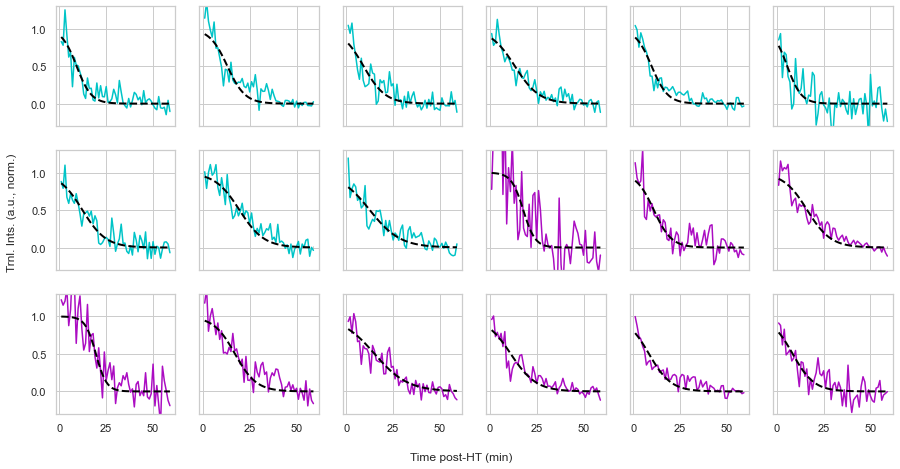

In [20]:
plt.rcParams["figure.figsize"] = (15,7.5)

# Set up the parameters for the figure
x_vals = []
y_vals = []
par_vals = []
col_vals = []
for i in np.arange(len(my_files)):
    temp_df =df_all[(df_all['File']==my_files[i]) & (df_all['Time (min)']>0)];
    temp_data = temp_df.groupby('Time (min)').agg('mean')[rchs[1]];
    par = df_fits[df_fits['File']==my_files[i]][['t_half (min)','runoff rate (aa/sec)']].values
    x_vals.append(temp_data.index)
    y_vals.append(temp_data.values)
    if i>8:
        col_vals.append((.67,.05,.76))
    else:
        col_vals.append((0,0.77,0.78))
#    print(par_vals)
    par_vals.append(par)
    
# Set up the figure    
fig, axes = plt.subplots(nrows=3, ncols=6, sharex=True, sharey=True)
fig.text(0.5, 0.04, 'Time post-HT (min)', ha='center')
fig.text(0.08, 0.5, 'Trnl. Ints. (a.u., norm.)', va='center', rotation='vertical')

# axes.flat returns the set of axes as a flat (1D) array instead
# of the two-dimensional version we used earlier
for ax, x, y, pars, col in zip(axes.flat,x_vals, y_vals, par_vals, col_vals):
    ax.plot(x, y, color=col)
    ax.plot(x, myf(x,pars[0][0],pars[0][1]), linestyle='--', linewidth=2, color='black')
    ax.grid(True)
    ax.set_ylim([-0.3, 1.3])

plt.savefig('Harringtonine-Summary.svg', format = 'svg', dpi=300)

### Fitting to Bertrand's function w/ 2 components

### Save some final plots for publication

### Other Figures

In [21]:
mydir=r'C:\Users\StasLab\OneDrive - Colostate\Stasevich Lab\Our papers\Ago2Tethering\Revision';
my_df= pd.read_excel(os.path.join(mydir,'MRE pbodies Quant.xlsx'))
my_df

,Cell,Total mRNA,In P-body,% mRNA foci in P-body,Replicate,Experiment
0,1,99,14,14.141414,Rep. 1,1
1,2,124,13,10.483871,Rep. 1,1
2,3,58,10,17.241379,Rep. 1,1
3,4,152,16,10.526316,Rep. 1,1
4,5,78,11,14.102564,Rep. 2,1
5,6,21,2,9.523810,Rep. 2,1
6,7,81,9,11.111111,Rep. 2,1


In [22]:
[np.median(my_df['% mRNA foci in P-body']),np.mean(my_df['% mRNA foci in P-body']),np.std(my_df['% mRNA foci in P-body'])]

[11.11111111111111, 12.447209278065618, 2.5765577691012362]

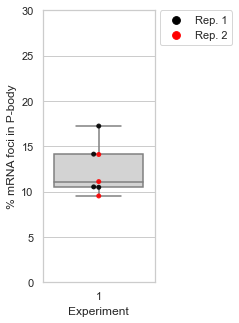

In [23]:
# Set figure size with matplotlib
plt.figure(figsize=(2,5))
sns.set_style("whitegrid")
# Create plot
sns.boxplot(x='Experiment',y='% mRNA foci in P-body', data=my_df[0:7],palette=["lightgray"])
sns.swarmplot(x='Experiment',y='% mRNA foci in P-body',data=my_df,  hue="Replicate",
              alpha=0.9,palette=["black","red"]) # and slightly transparent
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim(0, 30)
plt.savefig(os.path.join(mydir,'MRE-pbodies-Quant.svg'), format = 'svg', dpi=300)

In [24]:
mydir=r'C:\Users\StasLab\OneDrive - Colostate\Stasevich Lab\Our papers\Ago2Tethering\Revision';
my_df= pd.read_excel(os.path.join(mydir,'5e mRNA quant.xlsx'))
my_df

,Cell,Total mRNA,In RCK,% mRNA foci in P-body,Replicate,Experiment
0,0,122,35,28.688525,1,1
1,1,167,72,43.113772,1,1
2,2,88,76,86.363636,1,1
3,3,198,138,69.696970,1,1
4,4,80,35,43.750000,1,1
5,5,267,37,13.857678,1,1
6,6,332,95,28.614458,1,1
7,7,315,49,15.555556,1,1
8,8,208,50,24.038462,1,1
9,9,287,40,13.937282,1,1


In [25]:
my_df['% mRNA foci in P-body']

0    28.688525
1    43.113772
2    86.363636
3    69.696970
4    43.750000
5    13.857678
6    28.614458
7    15.555556
8    24.038462
9    13.937282
Name: % mRNA foci in P-body, dtype: float64

In [26]:
[np.median(my_df['% mRNA foci in P-body']),np.mean(my_df['% mRNA foci in P-body']),np.std(my_df['% mRNA foci in P-body'])]

[28.651491210744616, 36.761633816378904, 23.287233825498404]

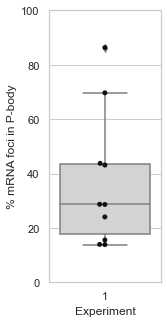

In [27]:
# Set figure size with matplotlib
plt.figure(figsize=(2,5))
sns.set_style("whitegrid") 
# Create plot
sns.boxplot(x='Experiment',y='% mRNA foci in P-body', data=my_df,palette=["lightgray"])
sns.swarmplot(x='Experiment',y='% mRNA foci in P-body',data=my_df,
              alpha=0.9,palette=["black"]) # and slightly transparent
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim(0, 100)
plt.savefig(os.path.join(mydir,'5E-mRNA-Quant.svg'), format = 'svg', dpi=300)

In [28]:
my_df['% mRNA foci in P-body'].median()

28.651491210744616

In [29]:
mydir=r'C:\Users\StasLab\OneDrive - Colostate\Stasevich Lab\Our papers\Ago2Tethering\Revision\HarringtonineAnalysis';
data_file= pd.read_excel(os.path.join(mydir,'photobleachanalysis.xlsx'))
data_file.head()

,Time post-HT (min),"Intensity (a.u., norm.)",Intensity (a.u.),AVG TL,AVG TA,Replicate
0,0,1.000000,0.983424,0.980146,0.986703,1
1,1,1.000069,0.983493,0.982107,0.984878,1
2,2,0.999625,0.983055,0.983207,0.982903,1
3,3,0.997523,0.980988,0.983817,0.978160,1
4,4,0.993334,0.976869,0.979801,0.973936,1


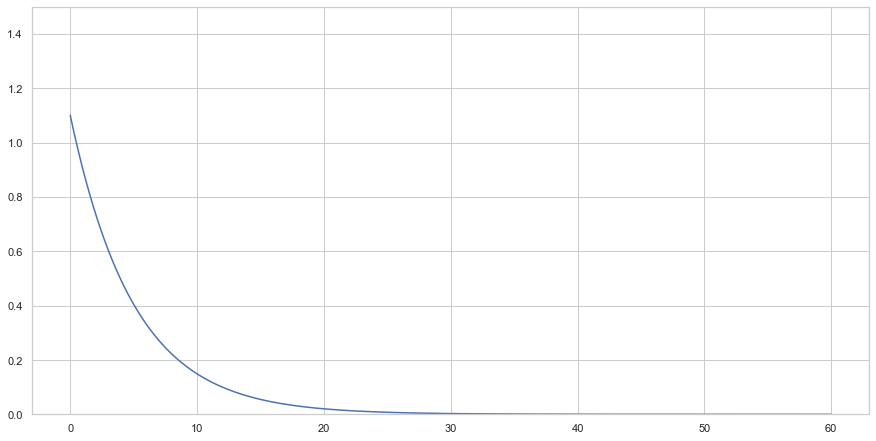

In [30]:
def my_exp(t,kpb,A):
    return A*np.exp(-kpb*t)
tt = np.linspace(0, 60, 200)
plt.plot(tt, my_exp(tt,.2,1.1))
plt.ylim(0,1.5)
plt.show() # or plt.savefig('foo.eps')

In [31]:
x_vals = data_file['Time post-HT (min)']
y_vals = data_file['Intensity (a.u., norm.)']
# Fit the datam to the function
pars, cov = curve_fit(f=my_exp, xdata=x_vals, 
                      ydata=y_vals, p0=[.1,1.1], bounds=(0, np.inf), maxfev=2000)
[pars,cov]

[array([5.52195558e-04, 9.91028821e-01]),
 array([[8.13048345e-10, 2.35028795e-08],
        [2.35028795e-08, 9.18838764e-07]])]

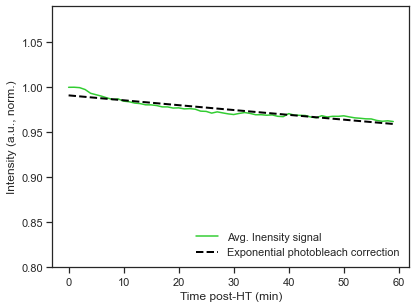

In [32]:
plt.rcParams["figure.figsize"] = (6.4,4.8)
sns.set_style("ticks") 
sns.lineplot(x='Time post-HT (min)',y='Intensity (a.u., norm.)',data=data_file,color='limegreen',ci=None)
plt.plot(x_vals, my_exp(x_vals,pars[0],pars[1]), linestyle='--', linewidth=2, color='black')
plt.ylim(0.8, 1.09)
plt.legend(('Avg. Inensity signal', 'Exponential photobleach correction'),loc='lower right',ncol=1, frameon=False)
plt.savefig(os.path.join(mydir,'Photobleach-Correction.svg'), format = 'svg', dpi=300)

## Revision Round 2 RCK analysis

#### Ago2-5XE mutant analysis of p-body, Ago2, and mRNA intensities

In [68]:
os.chdir(r'X:\Charlotte\Revision_Pbody_Ago2_5XE\smiFISH_TA_5XE')

In [69]:
import glob
my_RCK_files = glob.glob('*RCK*crop_pad_10*.tif')
my_Ago_files = glob.glob('*Ago*crop_pad_10*.tif')
my_Ago_files = [my_Ago_files[i] for i in [0,1,2,3,9,4,5,6,7,8]]
my_RNA_files = glob.glob('*RNA*crop_pad_10*.tif')
my_RCK_files, my_Ago_files, my_RNA_files

(['Particles_Cell02_RCK_crop_pad_10.tif',
  'Particles_Cell04_RCK_crop_pad_10.tif',
  'Particles_Cell06_RCK_crop_pad_10.tif',
  'Particles_Cell08_RCK_crop_pad_10.tif',
  'Particles_Cell12_RCK_crop_pad_10.tif',
  'Particles_RCK_Cell101_crop_pad_10.tif',
  'Particles_RCK_Cell102_crop_pad_10.tif',
  'Particles_RCK_Cell103_crop_pad_10.tif',
  'Particles_RCK_Cell104_crop_pad_10.tif',
  'Particles_RCK_Cell105_crop_pad_10.tif'],
 ['Particles_Ago_Cell02_crop_pad_10.tif',
  'Particles_Ago_Cell04_crop_pad_10.tif',
  'Particles_Ago_Cell06_crop_pad_10.tif',
  'Particles_Ago_Cell08_crop_pad_10.tif',
  'Particles_Ago_Cell12_crop_pad_10.tif',
  'Particles_Ago_Cell101_crop_pad_10.tif',
  'Particles_Ago_Cell102_crop_pad_10.tif',
  'Particles_Ago_Cell103_crop_pad_10.tif',
  'Particles_Ago_Cell104_crop_pad_10.tif',
  'Particles_Ago_Cell105_crop_pad_10.tif'],
 ['Particles_Cell02_RNA_crop_pad_10.tif',
  'Particles_Cell04_RNA_crop_pad_10.tif',
  'Particles_Cell06_RNA_crop_pad_10.tif',
  'Particles_Cell08_RN

In [70]:
my_tas_RCK = [imread(i) for i in my_RCK_files]
my_tas_RNA = [imread(i) for i in my_RNA_files]
my_tas_Ago = [imread(i) for i in my_Ago_files]


In [71]:
my_Ago_files[2][:-16]+'.xml'

'Particles_Ago_Cell06.xml'

In [72]:
my_spots_RCK = []
for my_files in my_RCK_files:
    spots = trackmate_peak_import(my_files[:-16]+'.xml')
    tracks=spots[['t','z','y','x']]
    tracks.columns=['POSITION_T','POSITION_Z','POSITION_Y','POSITION_X']
    tracks['TRACK_ID']=range(tracks.shape[0])
    my_spots_RCK.append(tracks)

my_spots_RNA = []
for my_files in my_RNA_files:
    spots = trackmate_peak_import(my_files[:-16]+'.xml')
    tracks=spots[['t','z','y','x']]
    tracks.columns=['POSITION_T','POSITION_Z','POSITION_Y','POSITION_X']
    tracks['TRACK_ID']=range(tracks.shape[0])
    my_spots_RNA.append(tracks)

my_spots_Ago = []
for my_files in my_Ago_files:
    spots = trackmate_peak_import(my_files[:-16]+'.xml')
    tracks=spots[['t','z','y','x']]
    tracks.columns=['POSITION_T','POSITION_Z','POSITION_Y','POSITION_X']
    tracks['TRACK_ID']=range(tracks.shape[0])
    my_spots_Ago.append(tracks)


In [73]:
from scipy.spatial import distance_matrix
overlap_Ago5XE = []
for i in np.arange(len(my_spots_Ago)):
    posAgo = np.transpose([my_spots_Ago[i]['POSITION_X'],my_spots_Ago[i]['POSITION_Y']])
    posRCK = np.transpose([my_spots_RCK[i]['POSITION_X'],my_spots_RCK[i]['POSITION_Y']])
    posRNA = np.transpose([my_spots_RNA[i]['POSITION_X'],my_spots_RNA[i]['POSITION_Y']])
    
    pair_dist = distance_matrix(posAgo,posRCK)
    temp = np.argwhere((pair_dist>0) & (pair_dist<5))
    posAgoandRCK = posAgo[np.unique(temp[:,0])]

    pair_dist = distance_matrix(posAgo,posRNA)
    temp = np.argwhere((pair_dist>0) & (pair_dist<5))
    posAgoandRNA = posAgo[np.unique(temp[:,0])]

    pair_dist = distance_matrix(posRCK,posRNA)
    temp = np.argwhere((pair_dist>0) & (pair_dist<5))
    posRCKandRNA = posRCK[np.unique(temp[:,0])]
    
    pair_dist = distance_matrix(posAgoandRNA,posRCK)
    temp = np.argwhere((pair_dist>0) & (pair_dist<5))
    posAgoandRCKandRNA = posAgoandRNA[np.unique(temp[:,0])]
    
    out = [len(posAgo),len(posRCK),len(posRNA),len(posAgoandRCK),len(posAgoandRNA),len(posRCKandRNA),len(posAgoandRCKandRNA)]
    overlap_Ago5XE.append(out)
df_overlap_Ago5XE = pd.DataFrame(np.array(overlap_Ago5XE),columns = ['# of Ago2 foci','# of RCK foci', '# of mRNA foci', '# of Ago2/RCK foci', '# of Ago2/mRNA foci', '# of RCK/mRNA foci', '# of RCK/Ago2/mRNA foci'])
df_overlap_Ago5XE

,# of Ago2 foci,# of RCK foci,# of mRNA foci,# of Ago2/RCK foci,# of Ago2/mRNA foci,# of RCK/mRNA foci,# of RCK/Ago2/mRNA foci
0,60,68,334,38,25,29,13
1,100,45,223,38,59,29,26
2,32,58,191,17,5,9,3
3,193,83,536,68,148,58,50
4,55,64,266,41,38,31,27
5,132,53,191,33,119,37,31
6,65,45,210,27,47,30,18
7,120,37,243,35,103,34,33
8,167,83,307,48,152,58,44
9,76,29,196,17,57,17,16


In [74]:
# Make track arrays with full z-stack
my_RCK = [TrackArray(my_tas_RCK[i], my_spots_RCK[i], 10) for i in np.arange(len(my_tas_RCK))]
my_RNA = [TrackArray(my_tas_RNA[i], my_spots_RNA[i], 10) for i in np.arange(len(my_tas_RNA))]
my_Ago = [TrackArray(my_tas_Ago[i], my_spots_Ago[i], 10) for i in np.arange(len(my_tas_Ago))]


In [75]:
# Make best-z projections and then background subtract. Create a track array from these background-subtracted best-z projections.
my_RNA_zbg = []
for i in np.arange(len(my_RNA)):
    ta = my_RNA[i]
    my_best_z_mask = ta.best_z_mask(1,0,z_offset=[0,0,0])
    best_z = ta.mask_projection(np.clip(ta.arr,0,1000000), my_best_z_mask) # best-z projection; clip to make sure data is +   
    best_z_bg = ta.local_background_subtract(best_z,ta.donut_mask_2D(5,1))
    my_RNA_zbg.append(TrackArray(np.array([best_z_bg]),my_spots_RNA[i],10))


In [76]:
my_RCK_zbg = []
for i in np.arange(len(my_RCK)):
    ta = my_RCK[i]
    my_best_z_mask = ta.best_z_mask(1,0,z_offset=[0,0,0])
    best_z = ta.mask_projection(np.clip(ta.arr,0,1000000), my_best_z_mask) # best-z projection; clip to make sure data is +   
    best_z_bg = ta.local_background_subtract(best_z,ta.donut_mask_2D(5,1))
    my_RCK_zbg.append(TrackArray(np.array([best_z_bg]), my_spots_RCK[i],10))


In [77]:
# Make best-z projections and then background subtract. Create a track array from these background-subtracted best-z projections.
my_Ago_zbg = []
for i in np.arange(len(my_Ago)):
    ta = my_Ago[i]
    my_best_z_mask = ta.best_z_mask(1,0,z_offset=[0,0,0])
    best_z = ta.mask_projection(np.clip(ta.arr,0,1000000), my_best_z_mask) # best-z projection; clip to make sure data is +   
    best_z_bg = ta.local_background_subtract(best_z,ta.donut_mask_2D(5,1))
    my_Ago_zbg.append(TrackArray(np.array([best_z_bg]),my_spots_Ago[i],10))

In [78]:
[my_RCK_zbg[1].disk_mask_2D(3).shape, my_RCK_zbg[1].n_frames()]

[(945, 21, 3), 1]

In [79]:
# myn=1
# print(my_RCK_files[myn])
# ta = my_RCK_zbg[myn]
# napari_viewer(ta.arr,[1,1],layer=[ta.donut_mask_2D(5,1),ta.disk_mask_2D(3)])

In [80]:
# myn=1
# print(my_RNA_files[myn])
# ta = my_RNA_zbg[myn]
# napari_viewer(ta.arr,[1,1],layer=[ta.donut_mask_2D(5,1),ta.disk_mask_2D(3)])

In [81]:
# myn=1
# print(my_Ago_files[myn])
# ta = my_Ago_zbg[myn]
# napari_viewer(ta.arr,[1,1],layer=[ta.donut_mask_2D(5,1),ta.disk_mask_2D(3)])

In [82]:
# Make dataframes from the measurements of intensities in 2D disk masks:
chs = ['mRNA Int. (a.u.)', 'Ago2 Int (a.u.)', 'RCK Int. (a.u.)']
rchs = ['Renorm. '+ c for c in chs]    
df_RNA = [my_RNA_zbg[i].measure_intensity_in_mask_df_new(my_RNA_zbg[i].arr, np.array([my_RNA_zbg[i].disk_mask_2D(3)]), dt=1, start_frame=0, renorm_frames=[0,1], file=my_RNA_files[i], ch_names = chs, replicate=i, exp='Ago2-5XE', ignore_val = -1) for i in np.arange(len(my_RNA_zbg))]



[69.29841816  8.65879496  5.0728637 ]
[97.59794107 43.74302416 16.32683544]
[63.09445912  1.67241061  4.13564276]
[93.40826012 43.13625278  8.11861609]
[76.83709118 11.58050873 21.72050992]
[437.32554927  48.56493291  10.64345561]
[210.98599258  26.83633598   5.72764712]
[390.61031587  18.05037695   5.92876103]
[275.13145028  38.92981886   8.25749115]
[148.03939752  33.79561625   5.17343705]


In [83]:
df_RCK = [my_RCK_zbg[i].measure_intensity_in_mask_df_new(my_RCK_zbg[i].arr, np.array([my_RCK_zbg[i].disk_mask_2D(3)]), dt=1, start_frame=0, renorm_frames=[0,1], file=my_RCK_files[i], ch_names = chs, replicate=i, exp='Ago2-5XE', ignore_val = -1) for i in np.arange(len(my_RCK_zbg))]

[ 23.08919174  75.72899842 134.59346087]
[106.96666209 192.36057743 132.96905105]
[  6.72259541  22.57190483 194.23070341]
[ 75.59555911 273.46121592 102.22908331]
[ 34.40300969  76.69863575 212.23587034]
[270.54344465  87.27321346  55.33842565]
[112.05656451 104.50254701  72.2443952 ]
[287.16057472  28.41805256  35.84930942]
[183.00207323  86.05133397  52.7567605 ]
[162.47880281 131.48976571  58.96231492]


In [84]:
df_Ago = [my_Ago_zbg[i].measure_intensity_in_mask_df_new(my_Ago_zbg[i].arr, np.array([my_Ago_zbg[i].disk_mask_2D(3)]), dt=1, start_frame=0, renorm_frames=[0,1], file=my_Ago_files[i], ch_names = chs, replicate=i, exp='Ago2-5XE', ignore_val = -1) for i in np.arange(len(my_Ago_zbg))]

[ 33.00225469  99.04198275 129.77124476]
[ 76.03555813 120.16597763  58.7282617 ]
[ 11.53253839  58.93168773 211.3983151 ]
[ 94.08355336 175.04993789  42.88605309]
[ 51.46526021 106.37072769 215.12217069]
[411.23544661  82.81534618  16.51567152]
[226.01176998  89.70957297  37.8774424 ]
[351.04060718  40.74061147  11.11989366]
[294.10671946  87.26934998  20.14102562]
[210.22328888  90.07803939  17.19467446]


In [85]:
df_RNA_Ago5XE = pd.concat(df_RNA)
df_RCK_Ago5XE = pd.concat(df_RCK)
df_Ago_Ago5XE = pd.concat(df_Ago)

#### Ago2-WT analysis of p-body, Ago2, and mRNA intensities

In [86]:
os.chdir(r'X:\Charlotte\Revision_Pbody_Ago2_5XE\smiFISH_TA_AGO2')

In [87]:
import glob
my_RCK_files = glob.glob('*RCK*crop_pad_10*.tif')
my_RNA_files = glob.glob('*RNA*crop_pad_10*.tif')
my_Ago_files = glob.glob('*Ago*crop_pad_10*.tif')
my_Ago_files = [my_Ago_files[i] for i in [0,1,2,8,9,3,4,5,6,7]]
my_RCK_files, my_RNA_files, my_Ago_files

(['Particles_Cell03_RCK_crop_pad_10.tif',
  'Particles_Cell08_RCK_crop_pad_10.tif',
  'Particles_Cell09_RCK_crop_pad_10.tif',
  'Particles_Cell10_RCK_crop_pad_10.tif',
  'Particles_Cell18_RCK_crop_pad_10.tif',
  'Particles_RCK_Cell101_crop_pad_10.tif',
  'Particles_RCK_Cell102_crop_pad_10.tif',
  'Particles_RCK_Cell103_crop_pad_10.tif',
  'Particles_RCK_Cell104_crop_pad_10.tif',
  'Particles_RCK_Cell105_crop_pad_10.tif'],
 ['Particles_Cell03_RNA_crop_pad_10.tif',
  'Particles_Cell08_RNA_crop_pad_10.tif',
  'Particles_Cell09_RNA_crop_pad_10.tif',
  'Particles_Cell10_RNA_crop_pad_10.tif',
  'Particles_Cell18_RNA_crop_pad_10.tif',
  'Particles_RNA_Cell101_crop_pad_10.tif',
  'Particles_RNA_Cell102_crop_pad_10.tif',
  'Particles_RNA_Cell103_crop_pad_10.tif',
  'Particles_RNA_Cell104_crop_pad_10.tif',
  'Particles_RNA_Cell105_crop_pad_10.tif'],
 ['Particles_Ago_Cell03_crop_pad_10.tif',
  'Particles_Ago_Cell08_crop_pad_10.tif',
  'Particles_Ago_Cell09_crop_pad_10.tif',
  'Particles_Ago_Cell1

In [88]:
my_tas_RCK = [imread(i) for i in my_RCK_files]
my_tas_RNA = [imread(i) for i in my_RNA_files]
my_tas_Ago = [imread(i) for i in my_Ago_files]


In [89]:
my_tas_RCK[5].shape

(15, 1491, 21, 3)

In [90]:
my_spots_RCK = []
for my_files in my_RCK_files:
    spots = trackmate_peak_import(my_files[:-16]+'.xml')
    tracks=spots[['t','z','y','x']]
    tracks.columns=['POSITION_T','POSITION_Z','POSITION_Y','POSITION_X']
    tracks['TRACK_ID']=range(tracks.shape[0])
    my_spots_RCK.append(tracks)

my_spots_RNA = []
for my_files in my_RNA_files:
    spots = trackmate_peak_import(my_files[:-16]+'.xml')
    tracks=spots[['t','z','y','x']]
    tracks.columns=['POSITION_T','POSITION_Z','POSITION_Y','POSITION_X']
    tracks['TRACK_ID']=range(tracks.shape[0])
    my_spots_RNA.append(tracks)

my_spots_Ago = []
for my_files in my_Ago_files:
    spots = trackmate_peak_import(my_files[:-16]+'.xml')
    tracks=spots[['t','z','y','x']]
    tracks.columns=['POSITION_T','POSITION_Z','POSITION_Y','POSITION_X']
    tracks['TRACK_ID']=range(tracks.shape[0])
    my_spots_Ago.append(tracks)


In [91]:
from scipy.spatial import distance_matrix
overlap_AgoWT = []
for i in np.arange(len(my_spots_Ago)):
    posAgo = np.transpose([my_spots_Ago[i]['POSITION_X'],my_spots_Ago[i]['POSITION_Y']])
    posRCK = np.transpose([my_spots_RCK[i]['POSITION_X'],my_spots_RCK[i]['POSITION_Y']])
    posRNA = np.transpose([my_spots_RNA[i]['POSITION_X'],my_spots_RNA[i]['POSITION_Y']])
    
    pair_dist = distance_matrix(posAgo,posRCK)
    temp = np.argwhere((pair_dist>0) & (pair_dist<5))
    posAgoandRCK = posAgo[np.unique(temp[:,0])]

    pair_dist = distance_matrix(posAgo,posRNA)
    temp = np.argwhere((pair_dist>0) & (pair_dist<5))
    posAgoandRNA = posAgo[np.unique(temp[:,0])]

    pair_dist = distance_matrix(posRCK,posRNA)
    temp = np.argwhere((pair_dist>0) & (pair_dist<5))
    posRCKandRNA = posRCK[np.unique(temp[:,0])]

    pair_dist = distance_matrix(posAgoandRNA,posRCK)
    temp = np.argwhere((pair_dist>0) & (pair_dist<5))
    posAgoandRCKandRNA = posAgoandRNA[np.unique(temp[:,0])]
    
    out = [len(posAgo),len(posRCK),len(posRNA),len(posAgoandRCK),len(posAgoandRNA),len(posRCKandRNA),len(posAgoandRCKandRNA)]
    overlap_AgoWT.append(out)
df_overlap_AgoWT = pd.DataFrame(np.array(overlap_AgoWT),columns = ['# of Ago2 foci','# of RCK foci', '# of mRNA foci', '# of Ago2/RCK foci', '# of Ago2/mRNA foci',  '# of RCK/mRNA foci','# of RCK/Ago2/mRNA foci'])
df_overlap_AgoWT


,# of Ago2 foci,# of RCK foci,# of mRNA foci,# of Ago2/RCK foci,# of Ago2/mRNA foci,# of RCK/mRNA foci,# of RCK/Ago2/mRNA foci
0,131,63,139,46,69,34,33
1,26,61,399,14,18,37,11
2,35,44,115,20,18,17,11
3,275,81,514,56,223,55,52
4,36,83,270,26,26,37,19
5,20,71,92,20,15,18,15
6,54,93,114,42,39,33,29
7,36,73,143,25,22,25,16
8,190,106,340,68,127,73,55
9,56,55,222,21,38,25,16


In [92]:
np.arange(5)

array([0, 1, 2, 3, 4])

In [93]:
# Make track arrays with full z-stack
# Get channels 0 (mRNA 5'? or is it 3'), Channel 2 = Ago2, and channel 3 = RCK GFP Movie 1-5
# Get channel 0 (mRNA), 1 (Ago2), 2 (RCK) for Movies 6-10
my_RCK1 = [TrackArray(my_tas_RCK[i][:,:,:,[0,2,3]], my_spots_RCK[i], 10) for i in np.arange(5)]
my_RCK2 = [TrackArray(my_tas_RCK[i][:,:,:,[0,1,2]], my_spots_RCK[i], 10) for i in np.arange(5,10,1)]
my_RCK=my_RCK1+my_RCK2

my_RNA1 = [TrackArray(my_tas_RNA[i][:,:,:,[0,2,3]], my_spots_RNA[i], 10) for i in np.arange(5)]
my_RNA2 = [TrackArray(my_tas_RNA[i][:,:,:,[0,1,2]], my_spots_RNA[i], 10) for i in np.arange(5,10,1)]
my_RNA = my_RNA1+my_RNA2

my_Ago1 = [TrackArray(my_tas_Ago[i][:,:,:,[0,2,3]], my_spots_Ago[i], 10) for i in np.arange(5)]
my_Ago2 = [TrackArray(my_tas_Ago[i][:,:,:,[0,1,2]], my_spots_Ago[i], 10) for i in np.arange(5,10,1)]
my_Ago=my_Ago1+my_Ago2


In [94]:
# Make best-z projections and then background subtract. Create a track array from these background-subtracted best-z projections.
my_RNA_zbg = []
for i in np.arange(len(my_RNA)):
    ta = my_RNA[i]
    my_best_z_mask = ta.best_z_mask(1,0,z_offset=[0,0,0])
    best_z = ta.mask_projection(np.clip(ta.arr,0,1000000), my_best_z_mask) # best-z projection; clip to make sure data is +   
    best_z_bg = ta.local_background_subtract(best_z,ta.donut_mask_2D(5,1))
    my_RNA_zbg.append(TrackArray(np.array([best_z_bg]),my_spots_RNA[i],10))


In [95]:
my_RCK_zbg = []
for i in np.arange(len(my_RCK)):
    ta = my_RCK[i]
    my_best_z_mask = ta.best_z_mask(1,0,z_offset=[0,0,0])
    best_z = ta.mask_projection(np.clip(ta.arr,0,1000000), my_best_z_mask) # best-z projection; clip to make sure data is +   
    best_z_bg = ta.local_background_subtract(best_z,ta.donut_mask_2D(5,1))
    my_RCK_zbg.append(TrackArray(np.array([best_z_bg]), my_spots_RCK[i],10))


In [96]:
my_Ago_zbg = []
for i in np.arange(len(my_Ago)):
    ta = my_Ago[i]
    my_best_z_mask = ta.best_z_mask(1,0,z_offset=[0,0,0])
    best_z = ta.mask_projection(np.clip(ta.arr,0,1000000), my_best_z_mask) # best-z projection; clip to make sure data is +   
    best_z_bg = ta.local_background_subtract(best_z,ta.donut_mask_2D(5,1))
    my_Ago_zbg.append(TrackArray(np.array([best_z_bg]), my_spots_Ago[i],10))

In [97]:
[my_RCK_zbg[1].disk_mask_2D(3).shape, my_RCK_zbg[1].n_frames()]

[(1281, 21, 3), 1]

In [98]:
# myn=1
# print(my_RCK_files[myn])
# ta = my_RCK_zbg[myn]
# napari_viewer(ta.arr,[1,1],layer=[ta.donut_mask_2D(5,1),ta.disk_mask_2D(3)])

In [99]:
# myn=1
# print(my_RNA_files[myn])
# ta = my_RNA_zbg[myn]
# napari_viewer(ta.arr,[1,1],layer=[ta.donut_mask_2D(5,1),ta.disk_mask_2D(3)])

In [100]:
# myn=1
# print(my_Ago_files[myn])
# ta = my_Ago_zbg[myn]
# napari_viewer(ta.arr,[1,1],layer=[ta.donut_mask_2D(5,1),ta.disk_mask_2D(3)])

In [101]:
# Make dataframes from the measurements of intensities in 2D disk masks:
chs = ['mRNA Int. (a.u.)', 'Ago2 Int (a.u.)', 'RCK Int. (a.u.)']
rchs = ['Renorm. '+ c for c in chs]    
df_RNA = [my_RNA_zbg[i].measure_intensity_in_mask_df_new(my_RNA_zbg[i].arr, np.array([my_RNA_zbg[i].disk_mask_2D(3)]), dt=1, start_frame=0, renorm_frames=[0,1], file=my_RNA_files[i], ch_names = chs, replicate=i, exp='Ago2-WT', ignore_val = -1) for i in np.arange(len(my_RNA_zbg))]



[87.90129826 62.57923902 26.42374004]
[32.49068288  3.9589604   2.27018407]
[30.86247479 12.11792997  9.30964525]
[84.09325577 20.3980421   6.94122289]
[50.05719516 20.45365276  3.89172446]
[24.26876574 14.99371695 33.39837371]
[56.839151   43.704446   29.15171542]
[55.81707686 33.3696974  15.95697484]
[89.38316342 25.82834103  6.71103654]
[40.84823831  7.6208493   6.73064523]


In [102]:
df_RCK = [my_RCK_zbg[i].measure_intensity_in_mask_df_new(my_RCK_zbg[i].arr, np.array([my_RCK_zbg[i].disk_mask_2D(3)]), dt=1, start_frame=0, renorm_frames=[0,1], file=my_RCK_files[i], ch_names = chs, replicate=i, exp='Ago2-WT', ignore_val = -1) for i in np.arange(len(my_RCK_zbg))]

[ 71.83058067 144.06019868 116.02674624]
[14.51688092 16.71890197 21.56041681]
[11.77694501 36.62665383 47.86289729]
[109.8053456   85.93351803  45.81148153]
[47.2312832  70.29256295 24.51101499]
[ 9.21141205 24.31021991 88.55886909]
[30.38844834 58.64947755 60.0689144 ]
[40.95701635 67.10924665 51.39618296]
[103.89379062  66.60373858  24.34959044]
[18.02951406 33.26048425 47.72730833]


In [103]:
df_Ago = [my_Ago_zbg[i].measure_intensity_in_mask_df_new(my_Ago_zbg[i].arr, np.array([my_Ago_zbg[i].disk_mask_2D(3)]), dt=1, start_frame=0, renorm_frames=[0,1], file=my_Ago_files[i], ch_names = chs, replicate=i, exp='Ago2-WT', ignore_val = -1) for i in np.arange(len(my_Ago_zbg))]

[62.73002025 85.52113635 51.65029206]
[36.43524135 43.60911311 29.5821163 ]
[19.63810702 49.69104014 45.17504049]
[91.17497348 39.8560756  14.72543037]
[114.37003539 165.473419    41.04724398]
[ 31.50457122  83.63543342 232.98439497]
[ 69.60951159 104.42665983  83.02544244]
[ 95.63211909 143.85952352  80.99602173]
[117.34947732  49.92197322  12.04218284]
[50.99337213 38.25703923 41.07649656]


In [104]:
df_RNA_Ago2WT = pd.concat(df_RNA)
df_RCK_Ago2WT = pd.concat(df_RCK)
df_Ago_Ago2WT = pd.concat(df_Ago)

#### Ago2-WT analysis of p-body, Ago2 intensities in cells w/o mRNA reporters

In [105]:
os.chdir(r'X:\Charlotte\Revision_Pbody_Ago2_5XE\noReporterControl\Ago2WT\Crops')

In [106]:
import glob
files = glob.glob('*crop_pad_10*.tif')
my_RCK_files = glob.glob('*RCK*crop_pad_10*.tif')
my_Ago_files = glob.glob('*Ago*crop_pad_10*.tif')
files,my_RCK_files, my_Ago_files

(['Particles_Ago_Cell01_crop_pad_10.tif',
  'Particles_Ago_Cell02_crop_pad_10.tif',
  'Particles_Ago_Cell03_crop_pad_10.tif',
  'Particles_RCK_Cell01_crop_pad_10.tif',
  'Particles_RCK_Cell02_crop_pad_10.tif',
  'Particles_RCK_Cell03_crop_pad_10.tif',
  'Particles_RCK_Cell04_crop_pad_10.tif',
  'Particles_RCK_Cell06_crop_pad_10.tif',
  'Particles_RCK_Cell07_crop_pad_10.tif',
  'Particles_RCK_Cell08_crop_pad_10.tif',
  'Particles_RCK_Cell09_crop_pad_10.tif',
  'Particles_RCK_Cell10_crop_pad_10.tif',
  'Particles_RCK_Cell11_crop_pad_10.tif'],
 ['Particles_RCK_Cell01_crop_pad_10.tif',
  'Particles_RCK_Cell02_crop_pad_10.tif',
  'Particles_RCK_Cell03_crop_pad_10.tif',
  'Particles_RCK_Cell04_crop_pad_10.tif',
  'Particles_RCK_Cell06_crop_pad_10.tif',
  'Particles_RCK_Cell07_crop_pad_10.tif',
  'Particles_RCK_Cell08_crop_pad_10.tif',
  'Particles_RCK_Cell09_crop_pad_10.tif',
  'Particles_RCK_Cell10_crop_pad_10.tif',
  'Particles_RCK_Cell11_crop_pad_10.tif'],
 ['Particles_Ago_Cell01_crop_pad

In [107]:
my_tas_RCK[0].shape

(15, 1323, 21, 4)

In [108]:
my_tas_RCK = [np.transpose(imread(i),(0,2,3,1)) for i in my_RCK_files]
my_tas_Ago = [np.transpose(imread(i),(0,2,3,1)) for i in my_Ago_files]

In [109]:
pixel_width = 0.1604938 # correction for pixels to micrometers
pixel_height = 0.1604938 
my_spots = []
for my_files in files:
    spots = trackmate_peak_import(my_files[:20]+'.xml')
    tracks=spots[['t','z','y','x']]
    tracks.columns=['POSITION_T','POSITION_Z','Y','X']
    tracks['POSITION_X']=tracks['X']/pixel_width
    tracks['POSITION_Y']=tracks['Y']/pixel_height
    tracks['TRACK_ID']=range(tracks.shape[0])
    my_spots.append(tracks)
my_spots_Ago = my_spots[:3]
my_spots_RCK = my_spots[3:]

In [110]:
len(my_spots_Ago),len(my_spots_RCK)

(3, 10)

In [111]:
# Make track arrays with full z-stack
# Get channels 0 (Ago?),Channel 1 = duplicate of Channel 0 (so napari works normal), Channel 2 = RCK?
my_RCK = [TrackArray(my_tas_RCK[i][:,:,:,[0,0,1]], my_spots_RCK[i], 10) for i in np.arange(len(my_tas_RCK))]
my_Ago = [TrackArray(my_tas_Ago[i][:,:,:,[0,0,1]], my_spots_Ago[i], 10) for i in np.arange(len(my_tas_Ago))]


In [112]:
my_tas_Ago[0].shape,my_Ago[0].arr.shape,my_best_z_mask.shape

((25, 2310, 21, 2), (25, 2310, 21, 3), (15, 1176, 21, 3))

In [113]:
# Make best-z projections and then background subtract. Create a track array from these background-subtracted best-z projections.
my_Ago_zbg = []
for i in np.arange(len(my_Ago)):
    ta = my_Ago[i]
    my_best_z_mask = ta.best_z_mask(1,0,z_offset=[0,0,0])
    best_z = ta.mask_projection(np.clip(ta.arr,0,1000000), my_best_z_mask) # best-z projection; clip to make sure data is +   
    best_z_bg = ta.local_background_subtract(best_z,ta.donut_mask_2D(5,1))
    my_Ago_zbg.append(TrackArray(np.array([best_z_bg]),my_spots_Ago[i],10))


In [114]:
my_RCK_zbg = []
for i in np.arange(len(my_RCK)):
    ta = my_RCK[i]
    my_best_z_mask = ta.best_z_mask(1,0,z_offset=[0,0,0])
    best_z = ta.mask_projection(np.clip(ta.arr,0,1000000), my_best_z_mask) # best-z projection; clip to make sure data is +   
    best_z_bg = ta.local_background_subtract(best_z,ta.donut_mask_2D(5,1))
    my_RCK_zbg.append(TrackArray(np.array([best_z_bg]), my_spots_RCK[i],10))


In [115]:
[my_RCK_zbg[1].disk_mask_2D(3).shape, my_RCK_zbg[1].n_frames(),np.arange(len(my_RCK)),ta.arr.shape]

[(525, 21, 3), 1, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), (19, 1680, 21, 3)]

In [116]:
# myn=1
# print(my_RCK_files[myn])
# ta = my_RCK_zbg[myn]
# napari_viewer(ta.arr[0],[1,1],layer=[ta.donut_mask_2D(5,1),ta.disk_mask_2D(3)])

In [117]:
# myn=1
# print(my_Ago_files[myn])
# ta = my_Ago_zbg[myn]
# napari_viewer(ta.arr,[1,1],layer=[ta.donut_mask_2D(5,1),ta.disk_mask_2D(3)])

In [118]:
# Make dataframes from the measurements of intensities in 2D disk masks:
chs = chs = ['mRNA Int. (a.u.)', 'Ago2 Int (a.u.)', 'RCK Int. (a.u.)']
rchs = ['Renorm. '+ c for c in chs]    
df_Ago = [my_Ago_zbg[i].measure_intensity_in_mask_df_new(my_Ago_zbg[i].arr, np.array([my_Ago_zbg[i].disk_mask_2D(3)]), dt=1, start_frame=0, renorm_frames=[0,1], file=my_Ago_files[i], ch_names = chs, replicate=i, exp='No mRNA', ignore_val = -1) for i in np.arange(len(my_Ago_zbg))]

[19.40938794 19.40938794 54.80747395]
[54.03103246 54.03103246 84.43326911]
[104.61162413 104.61162413  28.053124  ]


In [119]:
df_RCK = [my_RCK_zbg[i].measure_intensity_in_mask_df_new(my_RCK_zbg[i].arr, np.array([my_RCK_zbg[i].disk_mask_2D(3)]), dt=1, start_frame=0, renorm_frames=[0,1], file=my_RCK_files[i], ch_names = chs, replicate=i, exp='No mRNA', ignore_val = -1) for i in np.arange(len(my_RCK_zbg))]

[ 51.42840823  51.42840823 126.86500452]
[64.15389198 64.15389198 77.23219336]
[80.55279058 80.55279058 16.82934946]
[35.60988857 35.60988857 45.57963994]
[94.77531437 94.77531437 38.73276071]
[43.40497878 43.40497878  5.64314488]
[44.68068772 44.68068772 32.63494557]
[84.55503842 84.55503842 32.25220538]
[63.13983028 63.13983028 65.92124906]
[49.6478574  49.6478574  23.19534246]


In [120]:
df_Ago_norep = pd.concat(df_Ago)
df_RCK_norep = pd.concat(df_RCK)

#### Comparing everything

In [121]:
mydir = r'X:\Charlotte\Revision_Pbody_Ago2_5XE'

In [122]:
df_Ago_all = pd.concat([df_Ago_Ago2WT,df_Ago_Ago5XE])
df_RNA_all = pd.concat([df_RNA_Ago2WT,df_RNA_Ago5XE])
df_RCK_all = pd.concat([df_RCK_Ago2WT,df_RCK_Ago5XE,df_RCK_norep]) # Adding in the no reporter control here
df_Ago_all.reset_index(level=0, inplace=True)
df_RNA_all.reset_index(level=0, inplace=True)
df_RCK_all.reset_index(level=0, inplace=True)

In [123]:
df_Ago_all['Ago/RCK'] = df_Ago_all['Ago2 Int (a.u.)']/df_Ago_all['RCK Int. (a.u.)']
df_RNA_all['Ago/RCK'] = df_RNA_all['Ago2 Int (a.u.)']/df_RNA_all['RCK Int. (a.u.)']
df_RCK_all['Ago/RCK'] = df_RCK_all['Ago2 Int (a.u.)']/df_RCK_all['RCK Int. (a.u.)']
df_RCK_all.head()

,index,Crop Row,Frame,Original Time (min),Time (min),mRNA Int. (a.u.),Ago2 Int (a.u.),RCK Int. (a.u.),Renorm. mRNA Int. (a.u.),Renorm. Ago2 Int (a.u.),...,Renorm by Row mRNA Int. (a.u.),Renorm by Row Ago2 Int (a.u.),Renorm by Row RCK Int. (a.u.),BG mRNA Int. (a.u.),BG Ago2 Int (a.u.),BG RCK Int. (a.u.),Expt.,Rep.,File,Ago/RCK
0,0,0.0,0.0,0.0,0.0,0.941404,3.692847,2.063028,0.013106,0.025634,...,1.0,1.0,1.0,0.0,0.0,0.0,Ago2-WT,0,Particles_Cell03_RCK_crop_pad_10.tif,1.790013
1,1,1.0,0.0,0.0,0.0,48.779942,97.471243,190.479592,0.679097,0.676601,...,1.0,1.0,1.0,0.0,0.0,0.0,Ago2-WT,0,Particles_Cell03_RCK_crop_pad_10.tif,0.511715
2,2,2.0,0.0,0.0,0.0,201.780973,313.170480,554.214080,2.809124,2.173886,...,1.0,1.0,1.0,0.0,0.0,0.0,Ago2-WT,0,Particles_Cell03_RCK_crop_pad_10.tif,0.565071
3,3,3.0,0.0,0.0,0.0,45.432076,174.314471,290.474541,0.632489,1.210011,...,1.0,1.0,1.0,0.0,0.0,0.0,Ago2-WT,0,Particles_Cell03_RCK_crop_pad_10.tif,0.600102
4,4,4.0,0.0,0.0,0.0,14.554267,57.315193,185.305762,0.202619,0.397856,...,1.0,1.0,1.0,0.0,0.0,0.0,Ago2-WT,0,Particles_Cell03_RCK_crop_pad_10.tif,0.309301


In [124]:
df_overlap_Ago5XE['Expt.']='Ago2-5XE'
df_overlap_AgoWT['Expt.']='Ago2-WT'
df_overlap = pd.concat([df_overlap_Ago5XE,df_overlap_AgoWT])
df_long_pre = df_overlap.rename(columns={'# of Ago2 foci':'Ago2','# of RCK foci':'RCK','# of mRNA foci':'mRNA','# of Ago2/RCK foci':'Ago2/RCK','# of Ago2/mRNA foci':'Ago2/mRNA','# of RCK/mRNA foci':'RCK/mRNA','# of RCK/Ago2/mRNA foci':'RCK/Ago2/mRNA'})
df_long = pd.melt(df_long_pre, id_vars=['Expt.'],var_name='Type of foci',value_name='#')
df_long

,Expt.,Type of foci,#
0,Ago2-5XE,Ago2,60
1,Ago2-5XE,Ago2,100
2,Ago2-5XE,Ago2,32
3,Ago2-5XE,Ago2,193
4,Ago2-5XE,Ago2,55
...,...,...,...
135,Ago2-WT,RCK/Ago2/mRNA,15
136,Ago2-WT,RCK/Ago2/mRNA,29
137,Ago2-WT,RCK/Ago2/mRNA,16
138,Ago2-WT,RCK/Ago2/mRNA,55


In [125]:
df_long['foci class']='N/A'
df_long[(df_long['Type of foci']=='mRNA')|(df_long['Type of foci']=='Ago2')|(df_long['Type of foci']=='RCK')]['foci class']='single'
df_long[(df_long['Type of foci']=='Ago2/mRNA')|(df_long['Type of foci']=='Ago2/RCK')|(df_long['Type of foci']=='RCK/mRNA')]['foci class']='double'
df_long

,Expt.,Type of foci,#,foci class
0,Ago2-5XE,Ago2,60,N/A
1,Ago2-5XE,Ago2,100,N/A
2,Ago2-5XE,Ago2,32,N/A
3,Ago2-5XE,Ago2,193,N/A
4,Ago2-5XE,Ago2,55,N/A
...,...,...,...,...
135,Ago2-WT,RCK/Ago2/mRNA,15,N/A
136,Ago2-WT,RCK/Ago2/mRNA,29,N/A
137,Ago2-WT,RCK/Ago2/mRNA,16,N/A
138,Ago2-WT,RCK/Ago2/mRNA,55,N/A


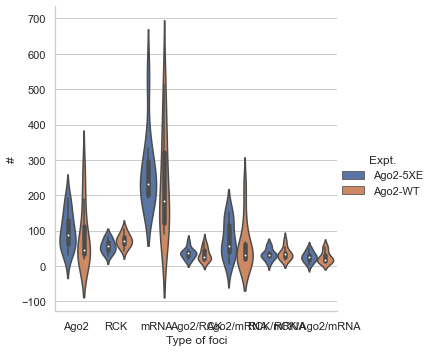

In [126]:
sns.catplot(data=df_long,hue='Expt.',x='Type of foci',y='#',kind='violin')

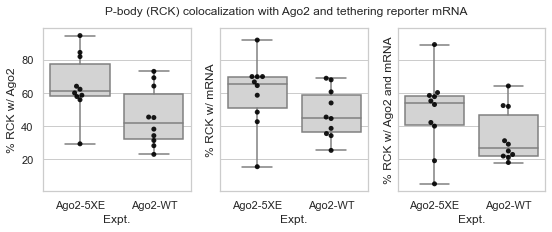

In [127]:
df_overlap['% RCK w/ Ago2'] = 100*df_overlap['# of Ago2/RCK foci']/df_overlap['# of RCK foci']
df_overlap['% RCK w/ mRNA'] = 100*df_overlap['# of RCK/mRNA foci']/df_overlap['# of RCK foci']
df_overlap['% RCK w/ Ago2 and mRNA'] = 100*df_overlap['# of RCK/Ago2/mRNA foci']/df_overlap['# of RCK foci']

sns.set_style("whitegrid") 
fig, axs = plt.subplots(1,3, figsize=(9, 3),sharey=True)
fig.suptitle('P-body (RCK) colocalization with Ago2 and tethering reporter mRNA')
# Create plot
sns.boxplot(ax=axs[0],x='Expt.',y='% RCK w/ Ago2', data=df_overlap,palette=["lightgray"],whis=2)
sns.swarmplot(ax=axs[0],x='Expt.',y='% RCK w/ Ago2',data=df_overlap,alpha=0.9,palette=["black"])

# Create plot
sns.boxplot(ax=axs[1],x='Expt.',y='% RCK w/ mRNA', data=df_overlap,palette=["lightgray"],whis=2)
sns.swarmplot(ax=axs[1],x='Expt.',y='% RCK w/ mRNA',data=df_overlap,alpha=0.9,palette=["black"]) # and slightly transparent

# Create plot
sns.boxplot(ax=axs[2],x='Expt.',y='% RCK w/ Ago2 and mRNA', data=df_overlap,palette=["lightgray"],whis=2)
sns.swarmplot(ax=axs[2],x='Expt.',y='% RCK w/ Ago2 and mRNA',data=df_overlap,alpha=0.9,palette=["black"]) # and slightly transparent

plt.savefig(os.path.join(mydir,'RCK-coloc.svg'), format = 'svg', dpi=300)

In [152]:
from scipy.stats import mannwhitneyu
data1 = df_overlap[(df_overlap['Expt.']=='Ago2-5XE')]['% RCK w/ Ago2']
data2 = df_overlap[(df_overlap['Expt.']=='Ago2-WT')]['% RCK w/ Ago2']
print(np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2))

data1 = df_overlap[(df_overlap['Expt.']=='Ago2-5XE')]['% RCK w/ mRNA']
data2 = df_overlap[(df_overlap['Expt.']=='Ago2-WT')]['% RCK w/ mRNA']
print(np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2))

data1 = df_overlap[(df_overlap['Expt.']=='Ago2-5XE')]['% RCK w/ Ago2 and mRNA']
data2 = df_overlap[(df_overlap['Expt.']=='Ago2-WT')]['% RCK w/ Ago2 and mRNA']
print(np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2))

64.89381135509487 5.497902628297137 45.17919831441027 5.341035304829983 1.4363648266506859 MannwhitneyuResult(statistic=74.0, pvalue=0.07566157214388704) 10 10
59.779584976031046 6.1544378511539595 47.51449320995603 4.4604505784590405 1.2581336964255998 MannwhitneyuResult(statistic=73.0, pvalue=0.08885290847904963) 10 10
48.0360519697926 6.996267700334945 33.77079024206784 4.87057174671378 1.4224142113782907 MannwhitneyuResult(statistic=70.0, pvalue=0.14046504815835495) 10 10


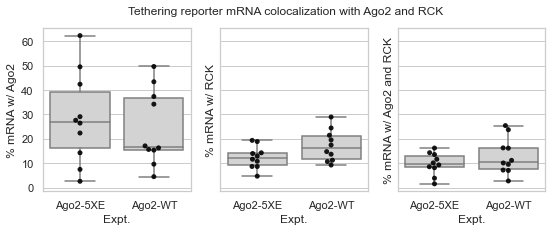

In [129]:
df_overlap['% mRNA w/ Ago2'] = 100*df_overlap['# of Ago2/mRNA foci']/df_overlap['# of mRNA foci']
df_overlap['% mRNA w/ RCK'] = 100*df_overlap['# of RCK/mRNA foci']/df_overlap['# of mRNA foci']
df_overlap['% mRNA w/ Ago2 and RCK'] = 100*df_overlap['# of RCK/Ago2/mRNA foci']/df_overlap['# of mRNA foci']

sns.set_style("whitegrid") 
fig, axs = plt.subplots(1,3, figsize=(9, 3),sharey=True)
fig.suptitle('Tethering reporter mRNA colocalization with Ago2 and RCK')
# Create plot
sns.boxplot(ax=axs[0],x='Expt.',y='% mRNA w/ Ago2', data=df_overlap,palette=["lightgray"],whis=2)
sns.swarmplot(ax=axs[0],x='Expt.',y='% mRNA w/ Ago2',data=df_overlap,alpha=0.9,palette=["black"])

# Create plot
sns.boxplot(ax=axs[1],x='Expt.',y='% mRNA w/ RCK', data=df_overlap,palette=["lightgray"],whis=2)
sns.swarmplot(ax=axs[1],x='Expt.',y='% mRNA w/ RCK',data=df_overlap,alpha=0.9,palette=["black"]) # and slightly transparent

# Create plot
sns.boxplot(ax=axs[2],x='Expt.',y='% mRNA w/ Ago2 and RCK', data=df_overlap,palette=["lightgray"],whis=2)
sns.swarmplot(ax=axs[2],x='Expt.',y='% mRNA w/ Ago2 and RCK',data=df_overlap,alpha=0.9,palette=["black"]) # and slightly transparent

plt.savefig(os.path.join(mydir,'mRNA-coloc.svg'), format = 'svg', dpi=300)

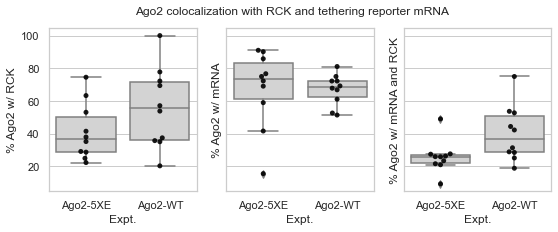

In [130]:
df_overlap['% Ago2 w/ RCK'] = 100*df_overlap['# of Ago2/RCK foci']/df_overlap['# of Ago2 foci']
df_overlap['% Ago2 w/ mRNA'] = 100*df_overlap['# of Ago2/mRNA foci']/df_overlap['# of Ago2 foci']
df_overlap['% Ago2 w/ mRNA and RCK'] = 100*df_overlap['# of RCK/Ago2/mRNA foci']/df_overlap['# of Ago2 foci']

sns.set_style("whitegrid") 
fig, axs = plt.subplots(1,3, figsize=(9, 3),sharey=True)
fig.suptitle('Ago2 colocalization with RCK and tethering reporter mRNA')
# Create plot
sns.boxplot(ax=axs[0],x='Expt.',y='% Ago2 w/ RCK', data=df_overlap,palette=["lightgray"],whis=2)
sns.swarmplot(ax=axs[0],x='Expt.',y='% Ago2 w/ RCK',data=df_overlap,alpha=0.9,palette=["black"])

# Create plot
sns.boxplot(ax=axs[1],x='Expt.',y='% Ago2 w/ mRNA', data=df_overlap,palette=["lightgray"],whis=2)
sns.swarmplot(ax=axs[1],x='Expt.',y='% Ago2 w/ mRNA',data=df_overlap,alpha=0.9,palette=["black"]) # and slightly transparent

# Create plot
sns.boxplot(ax=axs[2],x='Expt.',y='% Ago2 w/ mRNA and RCK', data=df_overlap,palette=["lightgray"],whis=2)
sns.swarmplot(ax=axs[2],x='Expt.',y='% Ago2 w/ mRNA and RCK',data=df_overlap,alpha=0.9,palette=["black"]) # and slightly transparent

plt.savefig(os.path.join(mydir,'Ago2-coloc.svg'), format = 'svg', dpi=300)

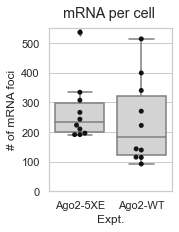

In [131]:
sns.set(font_scale=1)
sns.set_style("whitegrid") 
fig = plt.figure(figsize=(2.2,3))
fig.suptitle('mRNA per cell')
plt.ylim(0, 550)
# Create plot
sns.boxplot(x='Expt.',y='# of mRNA foci', data=df_overlap,palette=["lightgray"],whis=2)
sns.swarmplot(x='Expt.',y='# of mRNA foci',data=df_overlap,alpha=0.9,palette=["black"])
plt.savefig(os.path.join(mydir,'mRNA-per-cell.svg'), format = 'svg', dpi=300)

In [132]:
from scipy.stats import mannwhitneyu
data1 = df_overlap[(df_overlap['Expt.']=='Ago2-5XE')]['# of mRNA foci']
data2 = df_overlap[(df_overlap['Expt.']=='Ago2-WT')]['# of mRNA foci']
np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2)

(269.7,
 31.73832068651396,
 234.8,
 42.93315734953581,
 1.1486371379897784,
 MannwhitneyuResult(statistic=62.0, pvalue=0.3844942826161789),
 10,
 10)

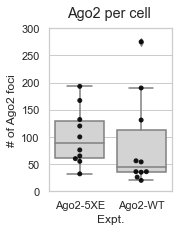

In [133]:
sns.set_style("whitegrid") 
fig = plt.figure(figsize=(2.2,3))
fig.suptitle('Ago2 per cell')
plt.ylim(0, 300)
# Create plot
sns.boxplot(x='Expt.',y='# of Ago2 foci', data=df_overlap,palette=["lightgray"],whis=2)
sns.swarmplot(x='Expt.',y='# of Ago2 foci',data=df_overlap,alpha=0.9,palette=["black"])
plt.savefig(os.path.join(mydir,'Ago2-per-cell.svg'), format = 'svg', dpi=300)

In [134]:
from scipy.stats import mannwhitneyu
data1 = df_overlap[(df_overlap['Expt.']=='Ago2-5XE')]['# of Ago2 foci']
data2 = df_overlap[(df_overlap['Expt.']=='Ago2-WT')]['# of Ago2 foci']
np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2)

(100.0,
 15.688212135230705,
 85.9,
 25.698813202169468,
 1.1641443538998835,
 MannwhitneyuResult(statistic=68.0, pvalue=0.18571128044479945),
 10,
 10)

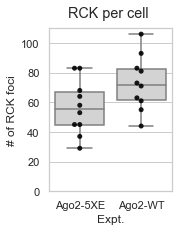

In [135]:
sns.set_style("whitegrid") 
fig = plt.figure(figsize=(2.2,3))
fig.suptitle('RCK per cell')
plt.ylim(0, 110)
# Create plot
sns.boxplot(x='Expt.',y='# of RCK foci', data=df_overlap,palette=["lightgray"],whis=2)
sns.swarmplot(x='Expt.',y='# of RCK foci',data=df_overlap,alpha=0.9,palette=["black"])
plt.savefig(os.path.join(mydir,'RCK-per-cell.svg'), format = 'svg', dpi=300)

In [136]:
from scipy.stats import mannwhitneyu
data1 = df_overlap[(df_overlap['Expt.']=='Ago2-5XE')]['# of RCK foci']
data2 = df_overlap[(df_overlap['Expt.']=='Ago2-WT')]['# of RCK foci']
np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2)

(56.5,
 5.4849794894785155,
 73.0,
 5.537147279962851,
 0.773972602739726,
 MannwhitneyuResult(statistic=28.0, pvalue=0.10345898986853651),
 10,
 10)

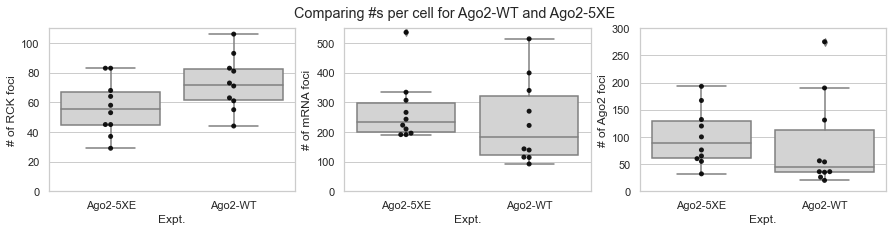

In [137]:
sns.set_style("whitegrid") 
fig, axs = plt.subplots(1,3, figsize=(15,3))
fig.suptitle('Comparing #s per cell for Ago2-WT and Ago2-5XE')
sns.set(font_scale=1)
# Create plot

axs[0].set_ylim(0, 110)
sns.boxplot(ax=axs[0],x='Expt.',y='# of RCK foci', data=df_overlap,palette=["lightgray"],whis=2)
sns.swarmplot(ax=axs[0],x='Expt.',y='# of RCK foci',data=df_overlap,alpha=0.9,palette=["black"])

# Create plot
axs[1].set_ylim(0, 550)
sns.boxplot(ax=axs[1],x='Expt.',y='# of mRNA foci', data=df_overlap,palette=["lightgray"],whis=2)
sns.swarmplot(ax=axs[1],x='Expt.',y='# of mRNA foci',data=df_overlap,alpha=0.9,palette=["black"]) # and slightly transparent

# Create plot
axs[2].set_ylim(0, 300)
sns.boxplot(ax=axs[2],x='Expt.',y='# of Ago2 foci', data=df_overlap,palette=["lightgray"],whis=2)
sns.swarmplot(ax=axs[2],x='Expt.',y='# of Ago2 foci',data=df_overlap,alpha=0.9,palette=["black"]) # and slightly transparent

plt.savefig(os.path.join(mydir,'Ago2-RCK-mRNA-numbers.svg'), format = 'svg', dpi=300)

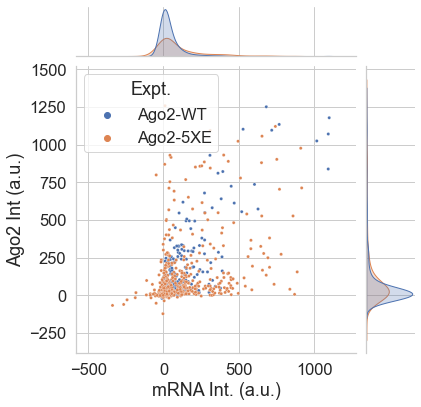

In [138]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid") 
p = sns.jointplot(x=chs[0], y=chs[1], data=df_RCK_all[(df_RCK_all['Expt.']=='Ago2-WT') |(df_RCK_all['Expt.']=='Ago2-5XE') ],hue='Expt.',marker = 'o',hue_order={'Ago2-WT','Ago2-5XE'}, s=10)
# p.ax_marg_x.set_xlim(-100, 400)
# p.ax_marg_y.set_ylim(-120, 400)
plt.savefig(os.path.join(mydir,'Revision2-InPbodies.svg'), format = 'svg', dpi=300,height=2)

The above plot would imply more P-bodies with the wild type than with the Ago2-5XE (which can't associate with mRNAs).Also, the mRNA and Ago2 signals are a little lower with the Ago-WT vs the mutant, suggesting more are being degraded with the Ago-WT?

In [139]:
from scipy.stats import mannwhitneyu
data1 = df_RCK_all[(df_RCK_all['Expt.']=='Ago2-5XE')]['Ago2 Int (a.u.)']
data2 = df_RCK_all[(df_RCK_all['Expt.']=='Ago2-WT')]['Ago2 Int (a.u.)']
np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2)

(113.37343144283724,
 8.768431385229087,
 62.28882321255608,
 5.943842796568436,
 1.820124792789208,
 MannwhitneyuResult(statistic=265735.0, pvalue=4.817604000740039e-19),
 565,
 730)

In [140]:
from scipy.stats import mannwhitneyu
data1 = df_RCK_all[(df_RCK_all['Expt.']=='Ago2-5XE')]['mRNA Int. (a.u.)']
data2 = df_RCK_all[(df_RCK_all['Expt.']=='Ago2-WT')]['mRNA Int. (a.u.)']
np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2)

(115.32220528404194,
 7.899117700344455,
 50.983335098256816,
 4.441931417335717,
 2.2619588354074733,
 MannwhitneyuResult(statistic=255053.0, pvalue=2.5568778306130787e-13),
 565,
 730)

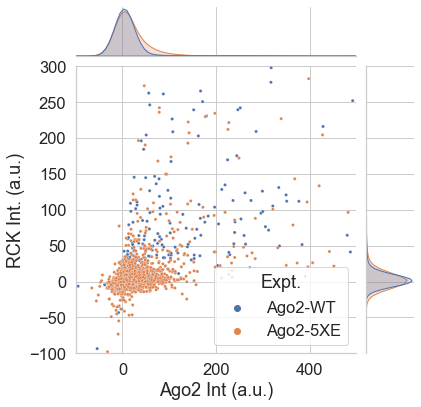

In [237]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid") 
p = sns.jointplot(x=chs[1], y=chs[2], data=df_RNA_all,hue='Expt.',marker = 'o',hue_order={'Ago2-WT','Ago2-5XE'}, s=10)
p.ax_marg_x.set_xlim(-100, 500)
p.ax_marg_y.set_ylim(-100, 300)
plt.savefig(os.path.join(mydir,'Revision2-InRNA.svg'), format = 'svg', dpi=300)

The above plot would imply mRNA #s are not impacted much by which Ago is co-transfected. Relative shifts in mean are also very small. Slightly more Ago2-5XE at mRNA foci, maybe because degradation of Ago2-WT bound mRNA? The RCK signal, in contrast, is not impacted.  

In [142]:
from scipy.stats import mannwhitneyu
data1 = df_RNA_all[(df_RNA_all['Expt.']=='Ago2-5XE')]['Ago2 Int (a.u.)']
data2 = df_RNA_all[(df_RNA_all['Expt.']=='Ago2-WT')]['Ago2 Int (a.u.)']
np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2)


(28.565361015587456,
 1.7099582944058729,
 20.990562728152103,
 1.9258639579195085,
 1.360866851715042,
 MannwhitneyuResult(statistic=3552562.0, pvalue=7.115539486646113e-14),
 2697,
 2348)

In [143]:
from scipy.stats import mannwhitneyu
data1 = df_RNA_all[(df_RNA_all['Expt.']=='Ago2-5XE')]['RCK Int. (a.u.)']
data2 = df_RNA_all[(df_RNA_all['Expt.']=='Ago2-WT')]['RCK Int. (a.u.)']
np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2)

(9.076678050013502,
 0.8820718655810252,
 9.677008384790083,
 0.7444245486712197,
 0.9379632308968384,
 MannwhitneyuResult(statistic=2991800.5, pvalue=0.000721806150523235),
 2697,
 2348)

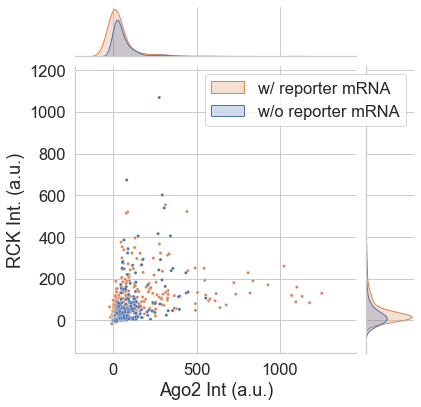

In [144]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid") 
sns.jointplot(x=chs[1], y=chs[2], data=df_RCK_all[(df_RCK_all['Expt.']=='No mRNA') |(df_RCK_all['Expt.']=='Ago2-WT') ],hue='Expt.',marker = 'o',hue_order={'No mRNA','Ago2-WT'}, s=10,legend=False)
# p.ax_marg_x.set_xlim(-100, 400)
# p.ax_marg_y.set_ylim(-120, 400)
plt.legend(loc='upper right', labels=['w/ reporter mRNA', 'w/o reporter mRNA'])
plt.savefig(os.path.join(mydir,'Revision2-NoReporterControl.svg'), format = 'svg', dpi=300,height=2)

The above plot shows more P-bodies (RCK foci) and Ago2 foci with reporter mRNA than without, suggesting our reporter helps make these. Very minor shift in mean values (6/60 or 10% for Ago2 and 7/50 or 13% for RCK). Note shift is in opposite directions.

In [145]:
from scipy.stats import mannwhitneyu
data1 = df_RCK_all[(df_RCK_all['Expt.']=='No mRNA')]['Ago2 Int (a.u.)']
data2 = df_RCK_all[(df_RCK_all['Expt.']=='Ago2-WT')]['Ago2 Int (a.u.)']
np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2), len(data1),len(data2)

(63.39363594644206,
 4.066744325108574,
 62.28882321255608,
 5.943842796568436,
 1.0177369338013642,
 MannwhitneyuResult(statistic=224483.0, pvalue=2.32958623344954e-39),
 420,
 730)

In [146]:
from scipy.stats import mannwhitneyu
data1 = df_RCK_all[(df_RCK_all['Expt.']=='No mRNA')]['RCK Int. (a.u.)']
data2 = df_RCK_all[(df_RCK_all['Expt.']=='Ago2-WT')]['RCK Int. (a.u.)']
np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2)

(44.82527363037567,
 4.780709576808921,
 51.106918923650824,
 2.7676903813922213,
 0.8770881629029649,
 MannwhitneyuResult(statistic=112620.0, pvalue=6.313839103195895e-14),
 420,
 730)

In [184]:
chs

['mRNA Int. (a.u.)', 'Ago2 Int (a.u.)', 'RCK Int. (a.u.)']

<AxesSubplot:xlabel='Expt.', ylabel='mRNA Int. (a.u.)'>

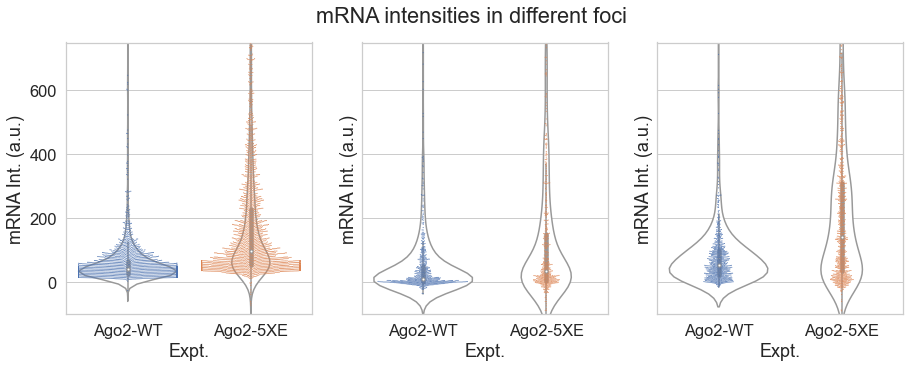

In [173]:
sns.set_style("whitegrid") 
fig, axs = plt.subplots(1,3, figsize=(15, 5),sharey=True,sharex=True)
fig.suptitle('mRNA intensities in different foci')
sns.swarmplot(ax=axs[0],x='Expt.', y=chs[0], data=df_RNA_all,hue='Expt.',marker='o',s=1)
sns.violinplot(ax=axs[0],x='Expt.', y=chs[0], data=df_RNA_all,color='white')
axs[0].get_legend().remove()
axs[0].set_ylim(-100, 750)
sns.swarmplot(ax=axs[1],x='Expt.', y=chs[0], data=df_RCK_all[df_RCK_all['Expt.']!='No mRNA'],marker = 'o', s=1)
sns.violinplot(ax=axs[1],x='Expt.', y=chs[0], data=df_RCK_all[df_RCK_all['Expt.']!='No mRNA'],marker = 'o', s=1,color='white')
#axs[1].get_legend().remove()
sns.swarmplot(ax=axs[2],x='Expt.', y=chs[0], data=df_Ago_all,marker = 'o', s=1)
sns.violinplot(ax=axs[2],x='Expt.', y=chs[0], data=df_Ago_all,marker = 'o', s=1,color='white')
#axs[2].get_legend().remove()

In [174]:
chs

['mRNA Int. (a.u.)', 'Ago2 Int (a.u.)', 'RCK Int. (a.u.)']

<AxesSubplot:xlabel='Expt.', ylabel='Ago2 Int (a.u.)'>

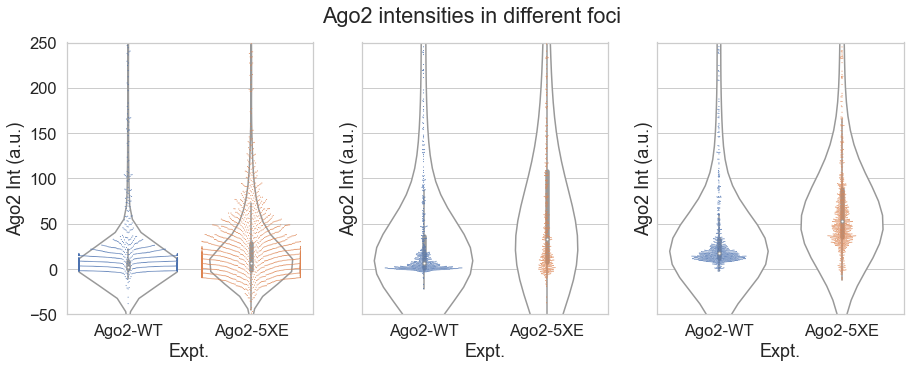

In [180]:
sns.set_style("whitegrid") 
fig, axs = plt.subplots(1,3, figsize=(15, 5),sharey=True,sharex=True)
fig.suptitle('Ago2 intensities in different foci')
sns.swarmplot(ax=axs[0],x='Expt.', y=chs[1], data=df_RNA_all,hue='Expt.',marker='o',s=1)
sns.violinplot(ax=axs[0],x='Expt.', y=chs[1], data=df_RNA_all,color='white')
axs[0].get_legend().remove()
axs[0].set_ylim(-50, 250)
sns.swarmplot(ax=axs[1],x='Expt.', y=chs[1], data=df_RCK_all[df_RCK_all['Expt.']!='No mRNA'],marker = 'o', s=1)
sns.violinplot(ax=axs[1],x='Expt.', y=chs[1], data=df_RCK_all[df_RCK_all['Expt.']!='No mRNA'],marker = 'o', s=1,color='white')
#axs[1].get_legend().remove()
sns.swarmplot(ax=axs[2],x='Expt.', y=chs[1], data=df_Ago_all,marker = 'o', s=1)
sns.violinplot(ax=axs[2],x='Expt.', y=chs[1], data=df_Ago_all,marker = 'o', s=1,color='white')
#axs[2].get_legend().remove()

<AxesSubplot:xlabel='Expt.', ylabel='RCK Int. (a.u.)'>

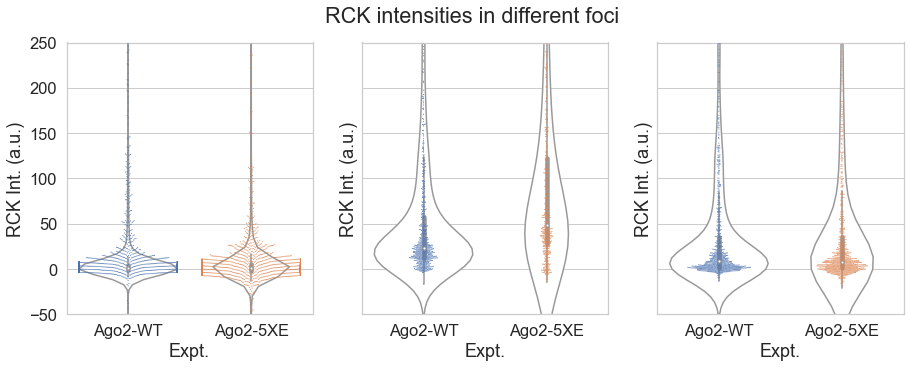

In [181]:
sns.set_style("whitegrid") 
fig, axs = plt.subplots(1,3, figsize=(15, 5),sharey=True,sharex=True)
fig.suptitle('RCK intensities in different foci')
sns.swarmplot(ax=axs[0],x='Expt.', y=chs[2], data=df_RNA_all,hue='Expt.',marker='o',s=1)
sns.violinplot(ax=axs[0],x='Expt.', y=chs[2], data=df_RNA_all,color='white')
axs[0].get_legend().remove()
axs[0].set_ylim(-50, 250)
sns.swarmplot(ax=axs[1],x='Expt.', y=chs[2], data=df_RCK_all[df_RCK_all['Expt.']!='No mRNA'],marker = 'o', s=1)
sns.violinplot(ax=axs[1],x='Expt.', y=chs[2], data=df_RCK_all[df_RCK_all['Expt.']!='No mRNA'],marker = 'o', s=1,color='white')
#axs[1].get_legend().remove()
sns.swarmplot(ax=axs[2],x='Expt.', y=chs[2], data=df_Ago_all,marker = 'o', s=1)
sns.violinplot(ax=axs[2],x='Expt.', y=chs[2], data=df_Ago_all,marker = 'o', s=1,color='white')
#axs[2].get_legend().remove()

In [235]:
# Plot the ratios of intensities relative to median RNA intensity in each foci (mRNA, Ago2, and RCK)
med_wt = np.median(df_RNA_all[df_RNA_all['Expt.']=='Ago2-WT'][chs[0]])
med_5xe = np.median(df_RNA_all[df_RNA_all['Expt.']=='Ago2-5XE'][chs[0]])
med_wt,med_5xe
ratioRNAwt  = df_RNA_all[df_RNA_all['Expt.']=='Ago2-WT'][chs[0]]/med_wt
ratioRNA5xe = df_RNA_all[df_RNA_all['Expt.']=='Ago2-5XE'][chs[0]]/med_5xe
ratioAgo2wt  = df_Ago_all[df_Ago_all['Expt.']=='Ago2-WT'][chs[0]]/med_wt
ratioAgo25xe = df_Ago_all[df_Ago_all['Expt.']=='Ago2-5XE'][chs[0]]/med_5xe
ratioRCKwt  = df_RCK_all[df_RCK_all['Expt.']=='Ago2-WT'][chs[0]]/med_wt
ratioRCK5xe = df_RCK_all[df_RCK_all['Expt.']=='Ago2-5XE'][chs[0]]/med_5xe
temp_df1 = pd.DataFrame({'Norm. mRNA int. (a.u.)':ratioRNAwt,'Norm. mRNA int. in Ago2 foci (a.u.)':ratioAgo2wt,'Norm. mRNA int. in RCK foci (a.u.)':ratioRCKwt})
temp_df1['Expt.'] = 'Ago2-WT'
temp_df2 = pd.DataFrame({'Norm. mRNA int. (a.u.)':ratioRNA5xe,'Norm. mRNA int. in Ago2 foci (a.u.)':ratioAgo25xe,'Norm. mRNA int. in RCK foci (a.u.)':ratioRCK5xe})
temp_df2['Expt.'] = 'Ago2-5XE'
norm_df = pd.concat([temp_df2,temp_df1])
norm_df

,Norm. mRNA int. (a.u.),Norm. mRNA int. in Ago2 foci (a.u.),Norm. mRNA int. in RCK foci (a.u.),Expt.
730,NaN,NaN,0.047138,Ago2-5XE
731,NaN,NaN,0.187011,Ago2-5XE
732,NaN,NaN,0.216902,Ago2-5XE
733,NaN,NaN,0.618177,Ago2-5XE
734,NaN,NaN,0.153581,Ago2-5XE
...,...,...,...,...
2343,0.481322,NaN,NaN,Ago2-WT
2344,1.064715,NaN,NaN,Ago2-WT
2345,3.221531,NaN,NaN,Ago2-WT
2346,0.254825,NaN,NaN,Ago2-WT


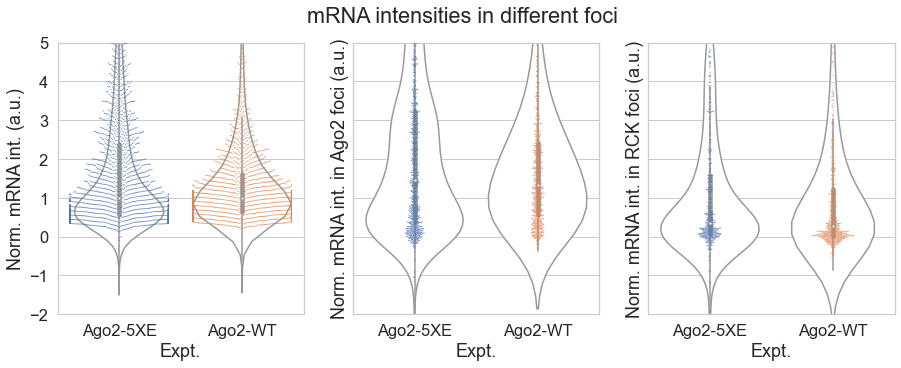

In [238]:
sns.set_style("whitegrid") 
fig, axs = plt.subplots(1,3, figsize=(15, 5),sharey=True,sharex=True)
fig.suptitle('mRNA intensities in different foci')
sns.swarmplot(ax=axs[0],x='Expt.', y='Norm. mRNA int. (a.u.)', data=norm_df,marker='o',s=1)
sns.violinplot(ax=axs[0],x='Expt.', y='Norm. mRNA int. (a.u.)', data=norm_df,color='white')
#axs[0].get_legend().remove()
axs[0].set_ylim(-2, 5)
sns.swarmplot(ax=axs[1],x='Expt.', y='Norm. mRNA int. in Ago2 foci (a.u.)', data=norm_df,marker = 'o', s=1)
sns.violinplot(ax=axs[1],x='Expt.', y='Norm. mRNA int. in Ago2 foci (a.u.)', data=norm_df,marker = 'o', s=1,color='white')
#axs[1].get_legend().remove()
sns.swarmplot(ax=axs[2],x='Expt.', y='Norm. mRNA int. in RCK foci (a.u.)', data=norm_df,marker = 'o', s=1)
sns.violinplot(ax=axs[2],x='Expt.', y='Norm. mRNA int. in RCK foci (a.u.)', data=norm_df,marker = 'o', s=1,color='white')
#axs[2].get_legend().remove()
plt.savefig(os.path.join(mydir,'Revision2-mRNAInOutFoci.svg'), format = 'svg', dpi=300)

In [243]:
from scipy.stats import mannwhitneyu
data1 = norm_df[(norm_df['Expt.']=='Ago2-5XE')]['Norm. mRNA int. (a.u.)'].dropna()
data2 = norm_df[(norm_df['Expt.']=='Ago2-WT')]['Norm. mRNA int. (a.u.)'].dropna()
print(np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2))

from scipy.stats import mannwhitneyu
data1 = norm_df[(norm_df['Expt.']=='Ago2-5XE')]['Norm. mRNA int. in Ago2 foci (a.u.)'].dropna()
data2 = norm_df[(norm_df['Expt.']=='Ago2-WT')]['Norm. mRNA int. in Ago2 foci (a.u.)'].dropna()
print(np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2))

from scipy.stats import mannwhitneyu
data1 = norm_df[(norm_df['Expt.']=='Ago2-5XE')]['Norm. mRNA int. in RCK foci (a.u.)'].dropna()
data2 = norm_df[(norm_df['Expt.']=='Ago2-WT')]['Norm. mRNA int. in RCK foci (a.u.)'].dropna()
print(np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2))

1.7803707603322407 0.03577804480458923 1.4619564143685446 0.03997776530959688 1.217800163420896 MannwhitneyuResult(statistic=3257947.0, pvalue=0.0756624025011981) 2697 2348
2.144872470206012 0.0687718211843304 2.032341111222144 0.09849230294178707 1.0553703108019092 MannwhitneyuResult(statistic=444871.0, pvalue=0.18283868217043286) 1000 859
1.1941673967064643 0.08179577209146201 1.2357357777637845 0.10766368195011272 0.9663614327550317 MannwhitneyuResult(statistic=222589.0, pvalue=0.01421578517192424) 565 730


In [244]:
chs

['mRNA Int. (a.u.)', 'Ago2 Int (a.u.)', 'RCK Int. (a.u.)']

0.5375629813020038 0.032179193469367276 1.2044264103174827 0.11050496566658816 0.44632281117142225 MannwhitneyuResult(statistic=2983961.0, pvalue=0.00041074835933549783) 2697 2348
1.9298858512542878 0.09833833586504193 3.6813687813573566 0.30049118618173076 0.5242305147550906 MannwhitneyuResult(statistic=411901.0, pvalue=0.12722110833989364) 1000 859
2.1335406814425855 0.16501048644943478 3.5740968318196096 0.3410542792814675 0.5969454051854487 MannwhitneyuResult(statistic=219932.0, pvalue=0.040008384104277726) 565 730


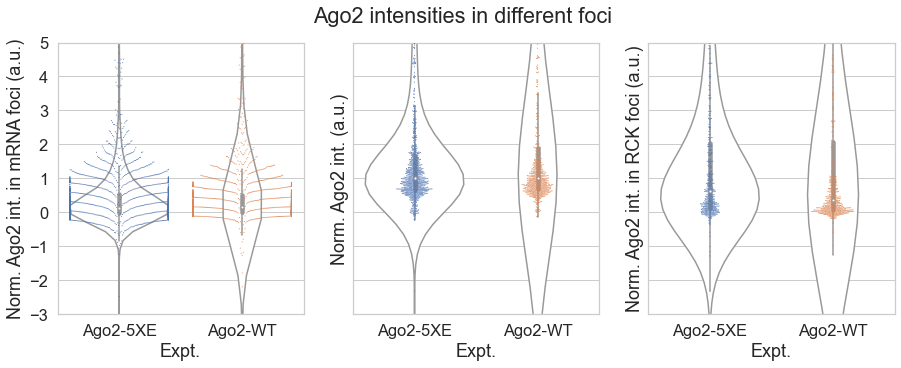

In [259]:
# Plot the ratios of intensities relative to median Ago2 intensity in each foci (mRNA, Ago2, and RCK)
med_wt = np.median(df_Ago_all[df_Ago_all['Expt.']=='Ago2-WT'][chs[1]])
med_5xe = np.median(df_Ago_all[df_Ago_all['Expt.']=='Ago2-5XE'][chs[1]])
med_wt,med_5xe
ratioRNAwt  = df_RNA_all[df_RNA_all['Expt.']=='Ago2-WT'][chs[1]]/med_wt
ratioRNA5xe = df_RNA_all[df_RNA_all['Expt.']=='Ago2-5XE'][chs[1]]/med_5xe
ratioAgo2wt  = df_Ago_all[df_Ago_all['Expt.']=='Ago2-WT'][chs[1]]/med_wt
ratioAgo25xe = df_Ago_all[df_Ago_all['Expt.']=='Ago2-5XE'][chs[1]]/med_5xe
ratioRCKwt  = df_RCK_all[df_RCK_all['Expt.']=='Ago2-WT'][chs[1]]/med_wt
ratioRCK5xe = df_RCK_all[df_RCK_all['Expt.']=='Ago2-5XE'][chs[1]]/med_5xe
temp_df1 = pd.DataFrame({'Norm. Ago2 int. in mRNA foci (a.u.)':ratioRNAwt,'Norm. Ago2 int. (a.u.)':ratioAgo2wt,'Norm. Ago2 int. in RCK foci (a.u.)':ratioRCKwt})
temp_df1['Expt.'] = 'Ago2-WT'
temp_df2 = pd.DataFrame({'Norm. Ago2 int. in mRNA foci (a.u.)':ratioRNA5xe,'Norm. Ago2 int. (a.u.)':ratioAgo25xe,'Norm. Ago2 int. in RCK foci (a.u.)':ratioRCK5xe})
temp_df2['Expt.'] = 'Ago2-5XE'
norm_df = pd.concat([temp_df2,temp_df1])
sns.set_style("whitegrid") 
fig, axs = plt.subplots(1,3, figsize=(15, 5),sharey=True,sharex=True)
fig.suptitle('Ago2 intensities in different foci')
sns.swarmplot(ax=axs[0],x='Expt.', y='Norm. Ago2 int. in mRNA foci (a.u.)', data=norm_df,marker='o',s=1)
sns.violinplot(ax=axs[0],x='Expt.', y='Norm. Ago2 int. in mRNA foci (a.u.)', data=norm_df,color='white')
#axs[0].get_legend().remove()
axs[0].set_ylim(-3, 5)
sns.swarmplot(ax=axs[1],x='Expt.', y='Norm. Ago2 int. (a.u.)', data=norm_df,marker = 'o', s=1)
sns.violinplot(ax=axs[1],x='Expt.', y='Norm. Ago2 int. (a.u.)', data=norm_df,marker = 'o', s=1,color='white')
#axs[1].get_legend().remove()
sns.swarmplot(ax=axs[2],x='Expt.', y='Norm. Ago2 int. in RCK foci (a.u.)', data=norm_df,marker = 'o', s=1)
sns.violinplot(ax=axs[2],x='Expt.', y='Norm. Ago2 int. in RCK foci (a.u.)', data=norm_df,marker = 'o', s=1,color='white')
#axs[2].get_legend().remove()
plt.savefig(os.path.join(mydir,'Revision2-Ago2InOutFoci.svg'), format = 'svg', dpi=300)

from scipy.stats import mannwhitneyu
data1 = norm_df[(norm_df['Expt.']=='Ago2-5XE')]['Norm. Ago2 int. in mRNA foci (a.u.)'].dropna()
data2 = norm_df[(norm_df['Expt.']=='Ago2-WT')]['Norm. Ago2 int. in mRNA foci (a.u.)'].dropna()
print(np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2))

from scipy.stats import mannwhitneyu
data1 = norm_df[(norm_df['Expt.']=='Ago2-5XE')]['Norm. Ago2 int. (a.u.)'].dropna()
data2 = norm_df[(norm_df['Expt.']=='Ago2-WT')]['Norm. Ago2 int. (a.u.)'].dropna()
print(np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2))

from scipy.stats import mannwhitneyu
data1 = norm_df[(norm_df['Expt.']=='Ago2-5XE')]['Norm. Ago2 int. in RCK foci (a.u.)'].dropna()
data2 = norm_df[(norm_df['Expt.']=='Ago2-WT')]['Norm. Ago2 int. in RCK foci (a.u.)'].dropna()
print(np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2))

0.18639832283547647 0.01811419502363184 0.41464925393889507 0.03189777991775665 0.4495325170968356 MannwhitneyuResult(statistic=2821550.0, pvalue=2.3826734993074342e-11) 2697 2348
1.0510184754873384 0.07968635004195425 1.5608606065036121 0.1020728249781089 0.6733583198320703 MannwhitneyuResult(statistic=358831.0, pvalue=9.102681222444187e-10) 1000 859
2.255994735365612 0.13662162860207455 2.189875730201416 0.11859251394076734 1.0301930398388928 MannwhitneyuResult(statistic=210252.0, pvalue=0.5463120467591194) 565 730


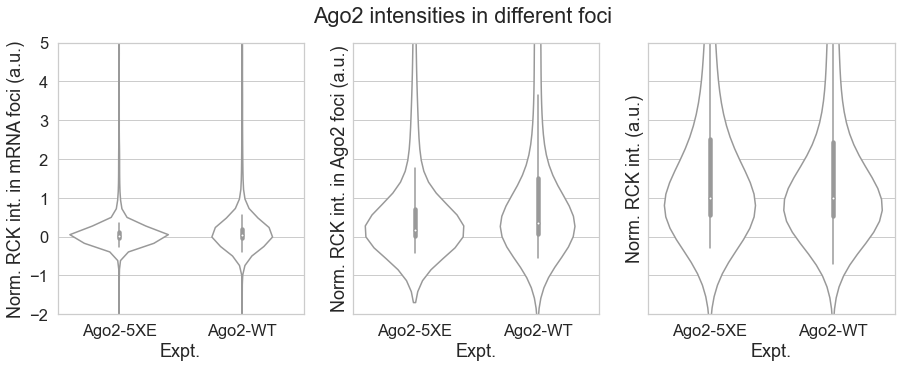

In [258]:
# Plot the ratios of intensities relative to median Ago2 intensity in each foci (mRNA, Ago2, and RCK)
med_wt = np.median(df_RCK_all[df_RCK_all['Expt.']=='Ago2-WT'][chs[2]])
med_5xe = np.median(df_RCK_all[df_RCK_all['Expt.']=='Ago2-5XE'][chs[2]])
med_wt,med_5xe
ratioRNAwt  = df_RNA_all[df_RNA_all['Expt.']=='Ago2-WT'][chs[2]]/med_wt
ratioRNA5xe = df_RNA_all[df_RNA_all['Expt.']=='Ago2-5XE'][chs[2]]/med_5xe
ratioAgo2wt  = df_Ago_all[df_Ago_all['Expt.']=='Ago2-WT'][chs[2]]/med_wt
ratioAgo25xe = df_Ago_all[df_Ago_all['Expt.']=='Ago2-5XE'][chs[2]]/med_5xe
ratioRCKwt  = df_RCK_all[df_RCK_all['Expt.']=='Ago2-WT'][chs[2]]/med_wt
ratioRCK5xe = df_RCK_all[df_RCK_all['Expt.']=='Ago2-5XE'][chs[2]]/med_5xe
temp_df1 = pd.DataFrame({'Norm. RCK int. in mRNA foci (a.u.)':ratioRNAwt,'Norm. RCK int. in Ago2 foci (a.u.)':ratioAgo2wt,'Norm. RCK int. (a.u.)':ratioRCKwt})
temp_df1['Expt.'] = 'Ago2-WT'
temp_df2 = pd.DataFrame({'Norm. RCK int. in mRNA foci (a.u.)':ratioRNA5xe,'Norm. RCK int. in Ago2 foci (a.u.)':ratioAgo25xe,'Norm. RCK int. (a.u.)':ratioRCK5xe})
temp_df2['Expt.'] = 'Ago2-5XE'
norm_df = pd.concat([temp_df2,temp_df1])
sns.set_style("whitegrid") 
fig, axs = plt.subplots(1,3, figsize=(15, 5),sharey=True,sharex=True)
fig.suptitle('Ago2 intensities in different foci')
sns.swarmplot(ax=axs[0],x='Expt.', y='Norm. RCK int. in mRNA foci (a.u.)', data=norm_df,marker='o',s=1)
sns.violinplot(ax=axs[0],x='Expt.', y='Norm. RCK int. in mRNA foci (a.u.)', data=norm_df,color='white')
#axs[0].get_legend().remove()
axs[0].set_ylim(-2, 5)
sns.swarmplot(ax=axs[1],x='Expt.', y='Norm. RCK int. in Ago2 foci (a.u.)', data=norm_df,marker = 'o', s=1)
sns.violinplot(ax=axs[1],x='Expt.', y='Norm. RCK int. in Ago2 foci (a.u.)', data=norm_df,marker = 'o', s=1,color='white')
#axs[1].get_legend().remove()
sns.swarmplot(ax=axs[2],x='Expt.', y='Norm. RCK int. (a.u.)', data=norm_df,marker = 'o', s=1)
sns.violinplot(ax=axs[2],x='Expt.', y='Norm. RCK int. (a.u.)', data=norm_df,marker = 'o', s=1,color='white')
#axs[2].get_legend().remove()
plt.savefig(os.path.join(mydir,'Revision2-RCKInOutFoci.svg'), format = 'svg', dpi=300)

from scipy.stats import mannwhitneyu
data1 = norm_df[(norm_df['Expt.']=='Ago2-5XE')]['Norm. RCK int. in mRNA foci (a.u.)'].dropna()
data2 = norm_df[(norm_df['Expt.']=='Ago2-WT')]['Norm. RCK int. in mRNA foci (a.u.)'].dropna()
print(np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2))

from scipy.stats import mannwhitneyu
data1 = norm_df[(norm_df['Expt.']=='Ago2-5XE')]['Norm. RCK int. in Ago2 foci (a.u.)'].dropna()
data2 = norm_df[(norm_df['Expt.']=='Ago2-WT')]['Norm. RCK int. in Ago2 foci (a.u.)'].dropna()
print(np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2))

from scipy.stats import mannwhitneyu
data1 = norm_df[(norm_df['Expt.']=='Ago2-5XE')]['Norm. RCK int. (a.u.)'].dropna()
data2 = norm_df[(norm_df['Expt.']=='Ago2-WT')]['Norm. RCK int. (a.u.)'].dropna()
print(np.mean(data1),np.std(data1)/np.sqrt(len(data1)),np.mean(data2),np.std(data2)/np.sqrt(len(data2)),np.mean(data1)/np.mean(data2),mannwhitneyu(data1,data2),len(data1),len(data2))